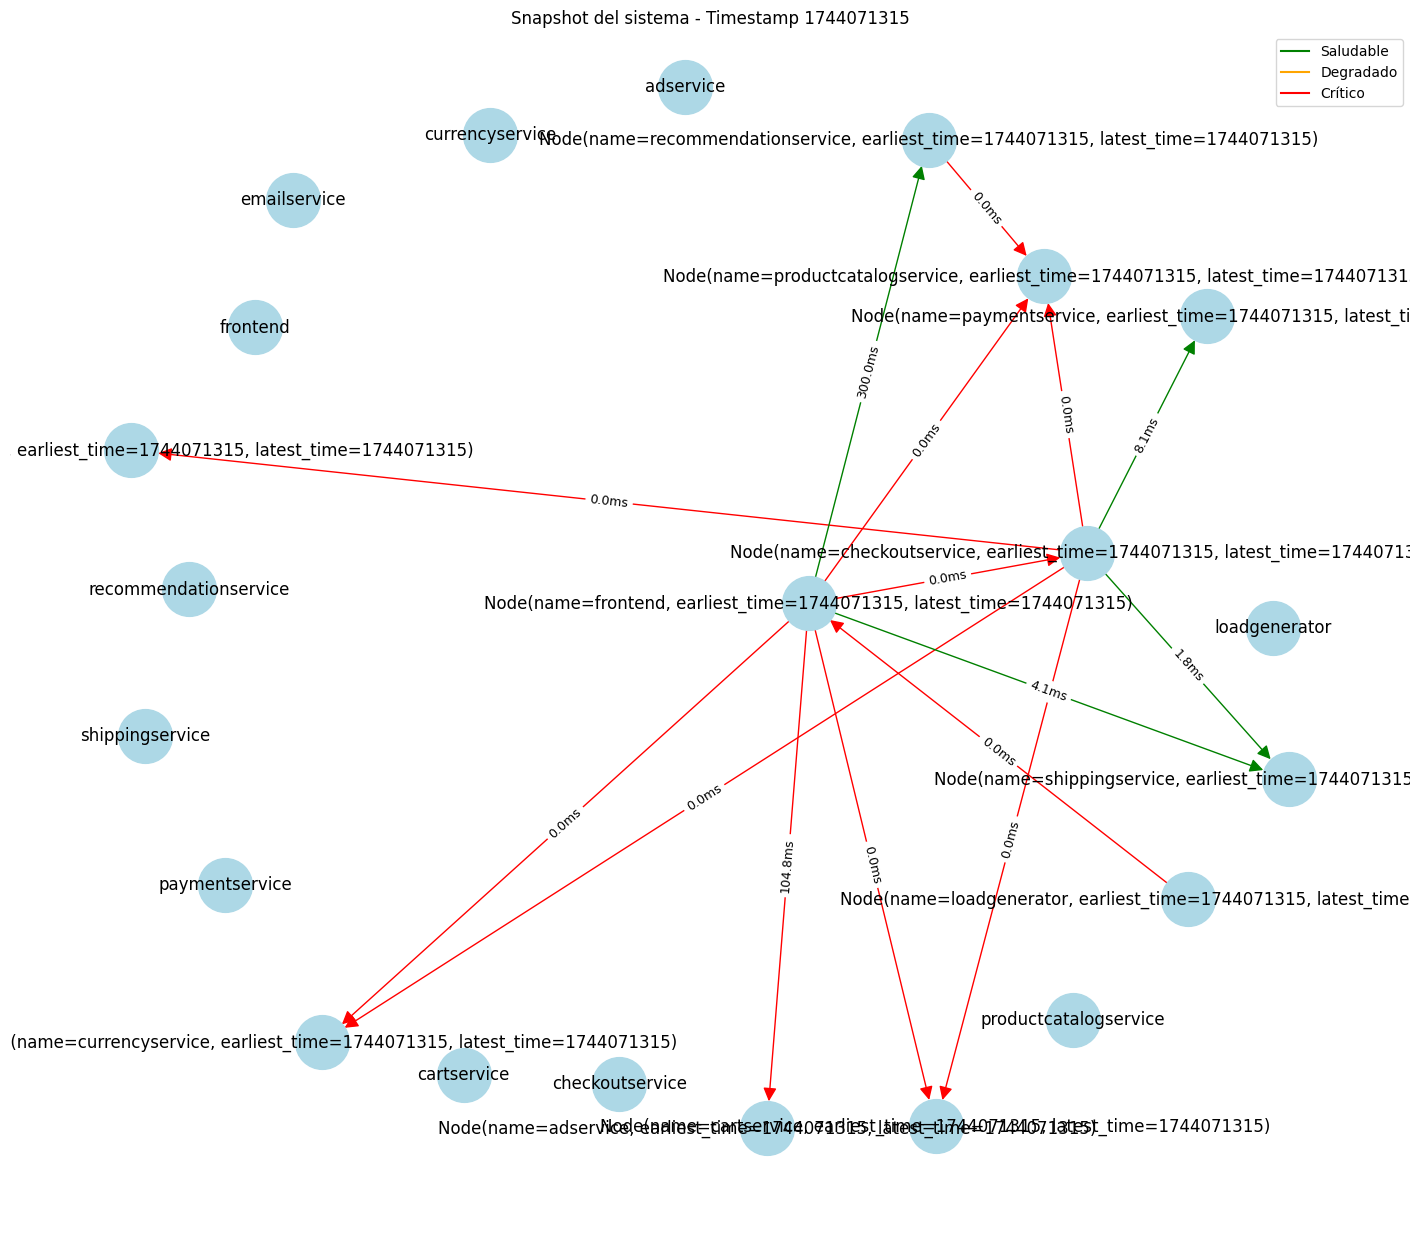

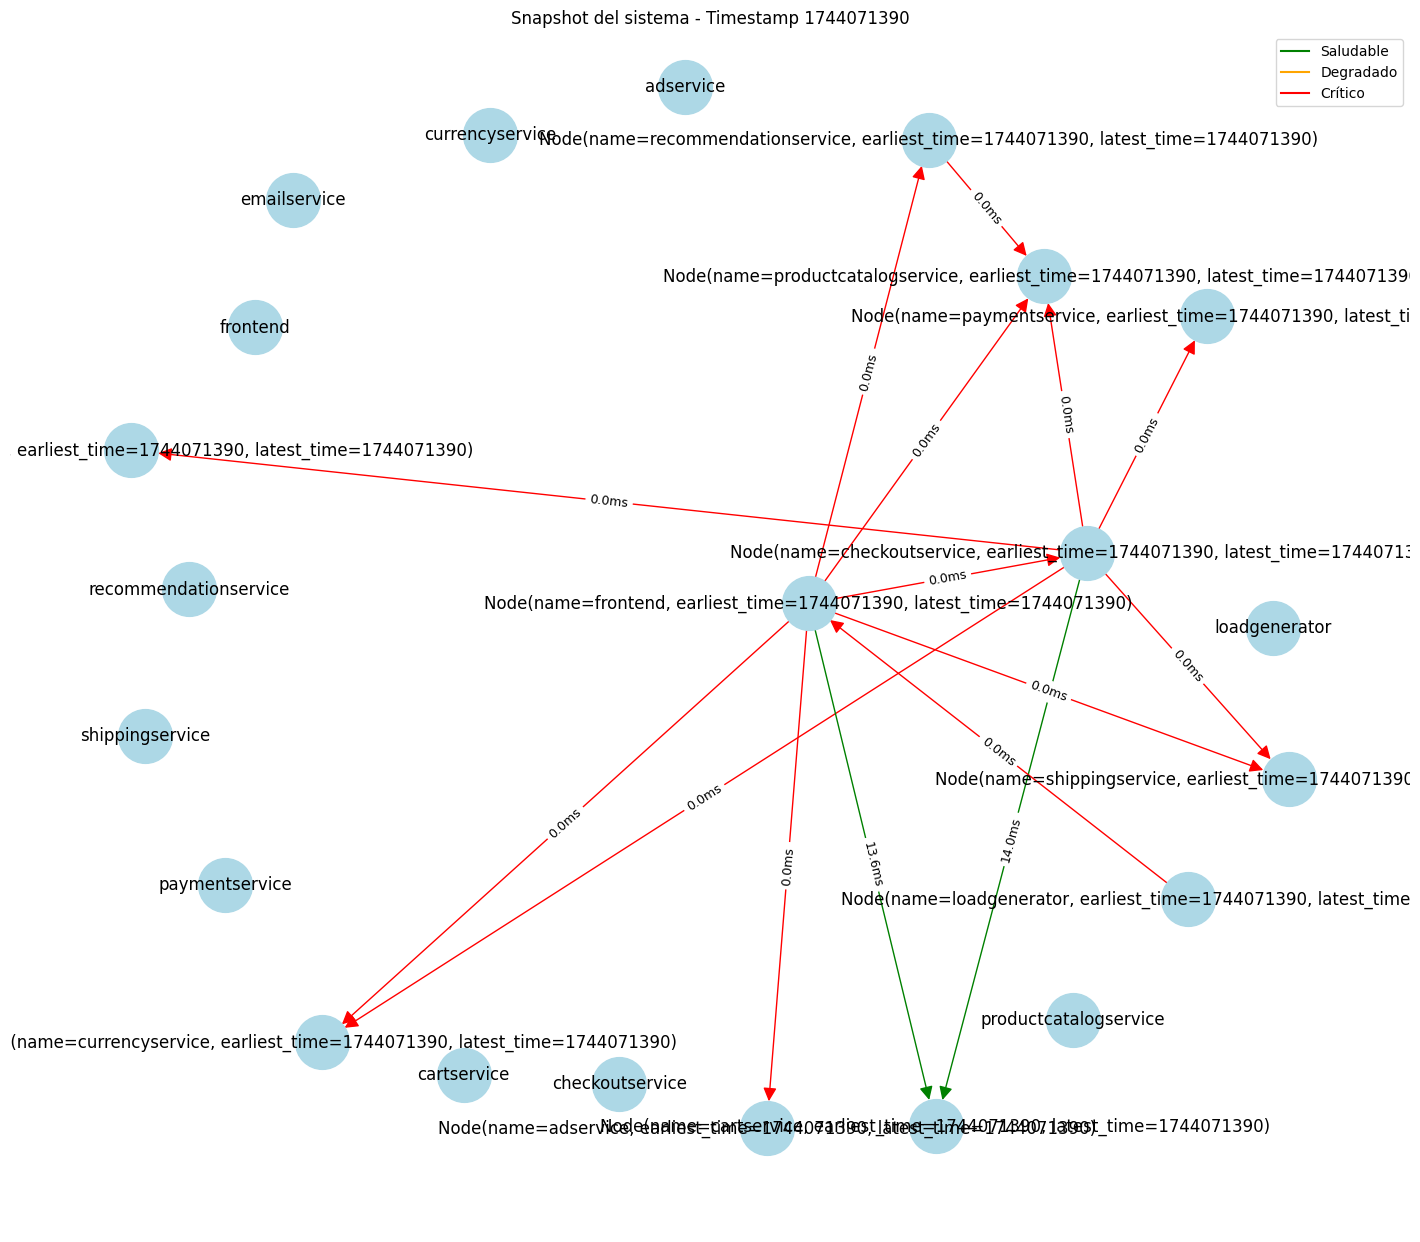

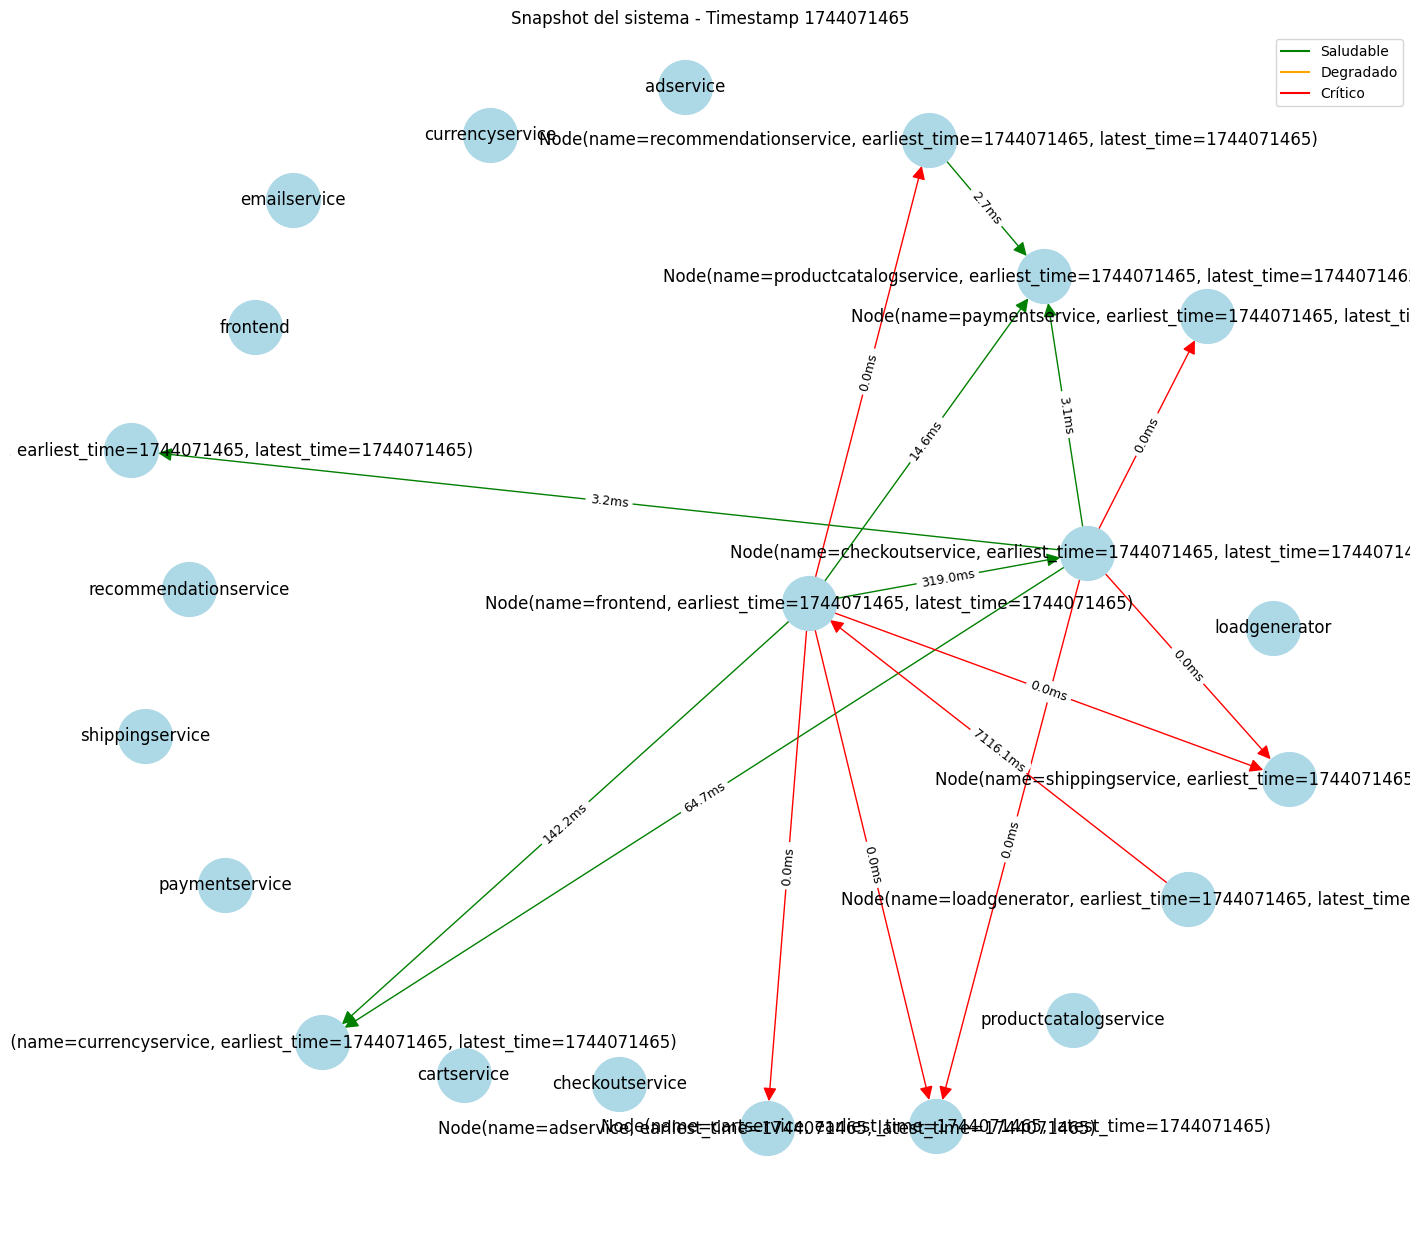

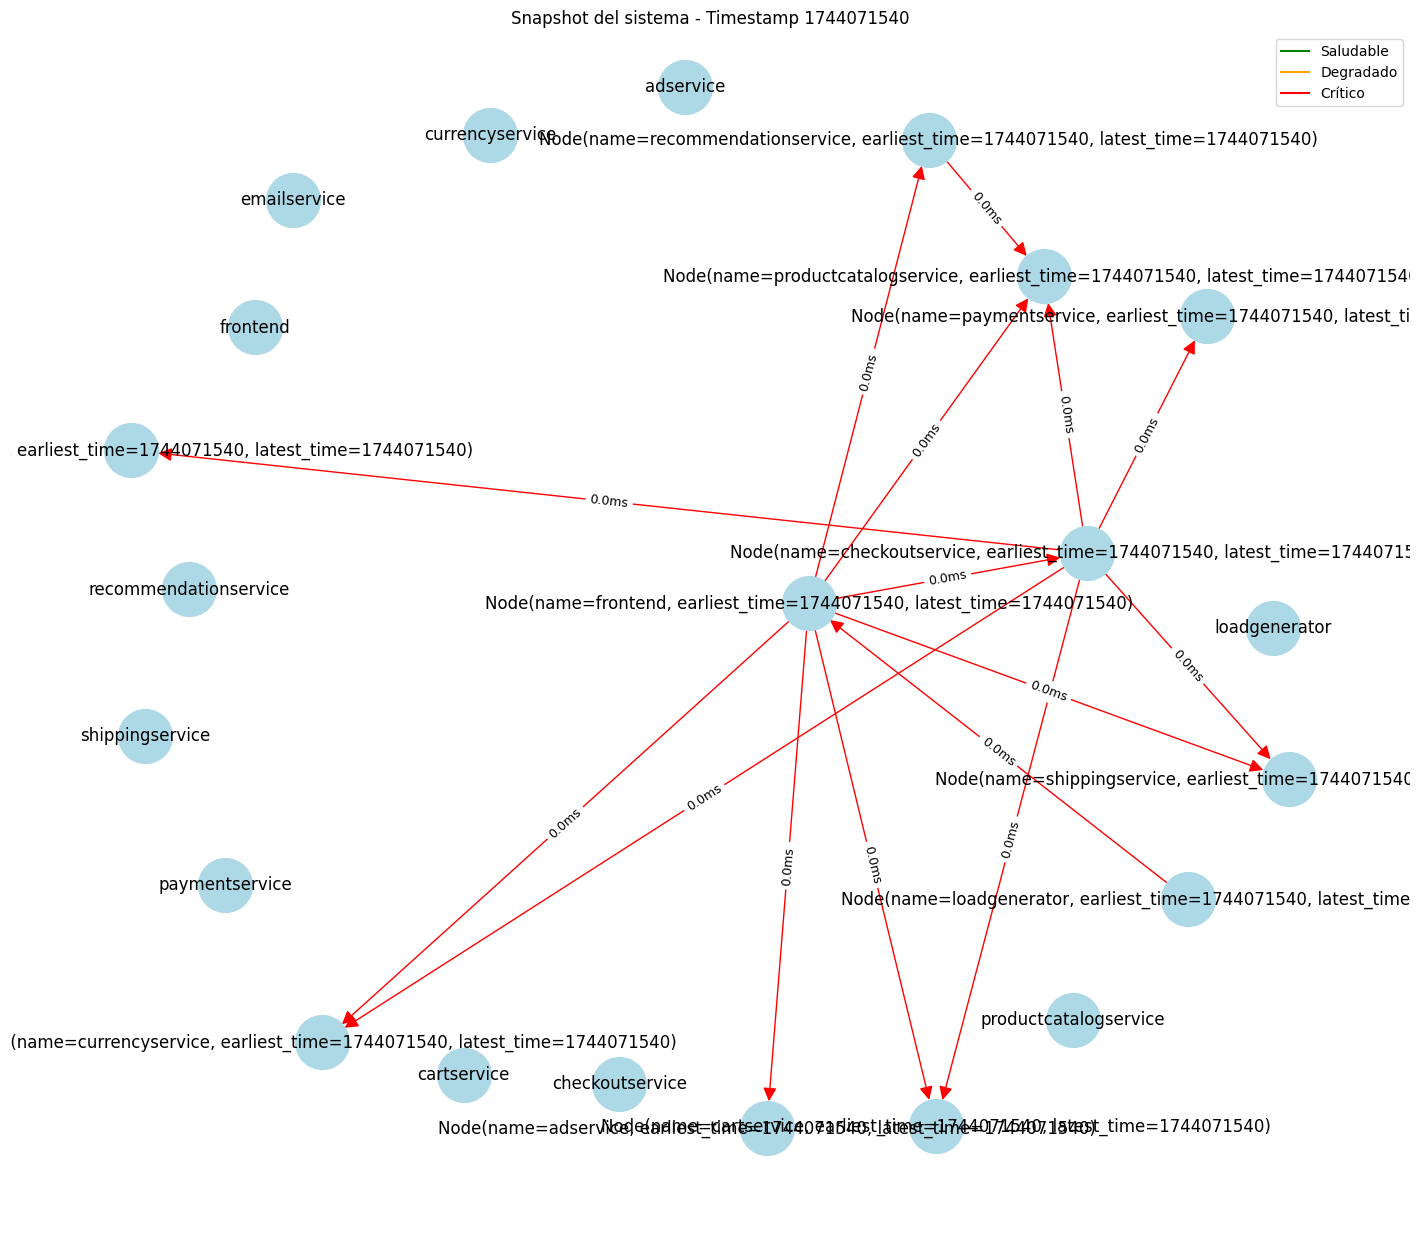

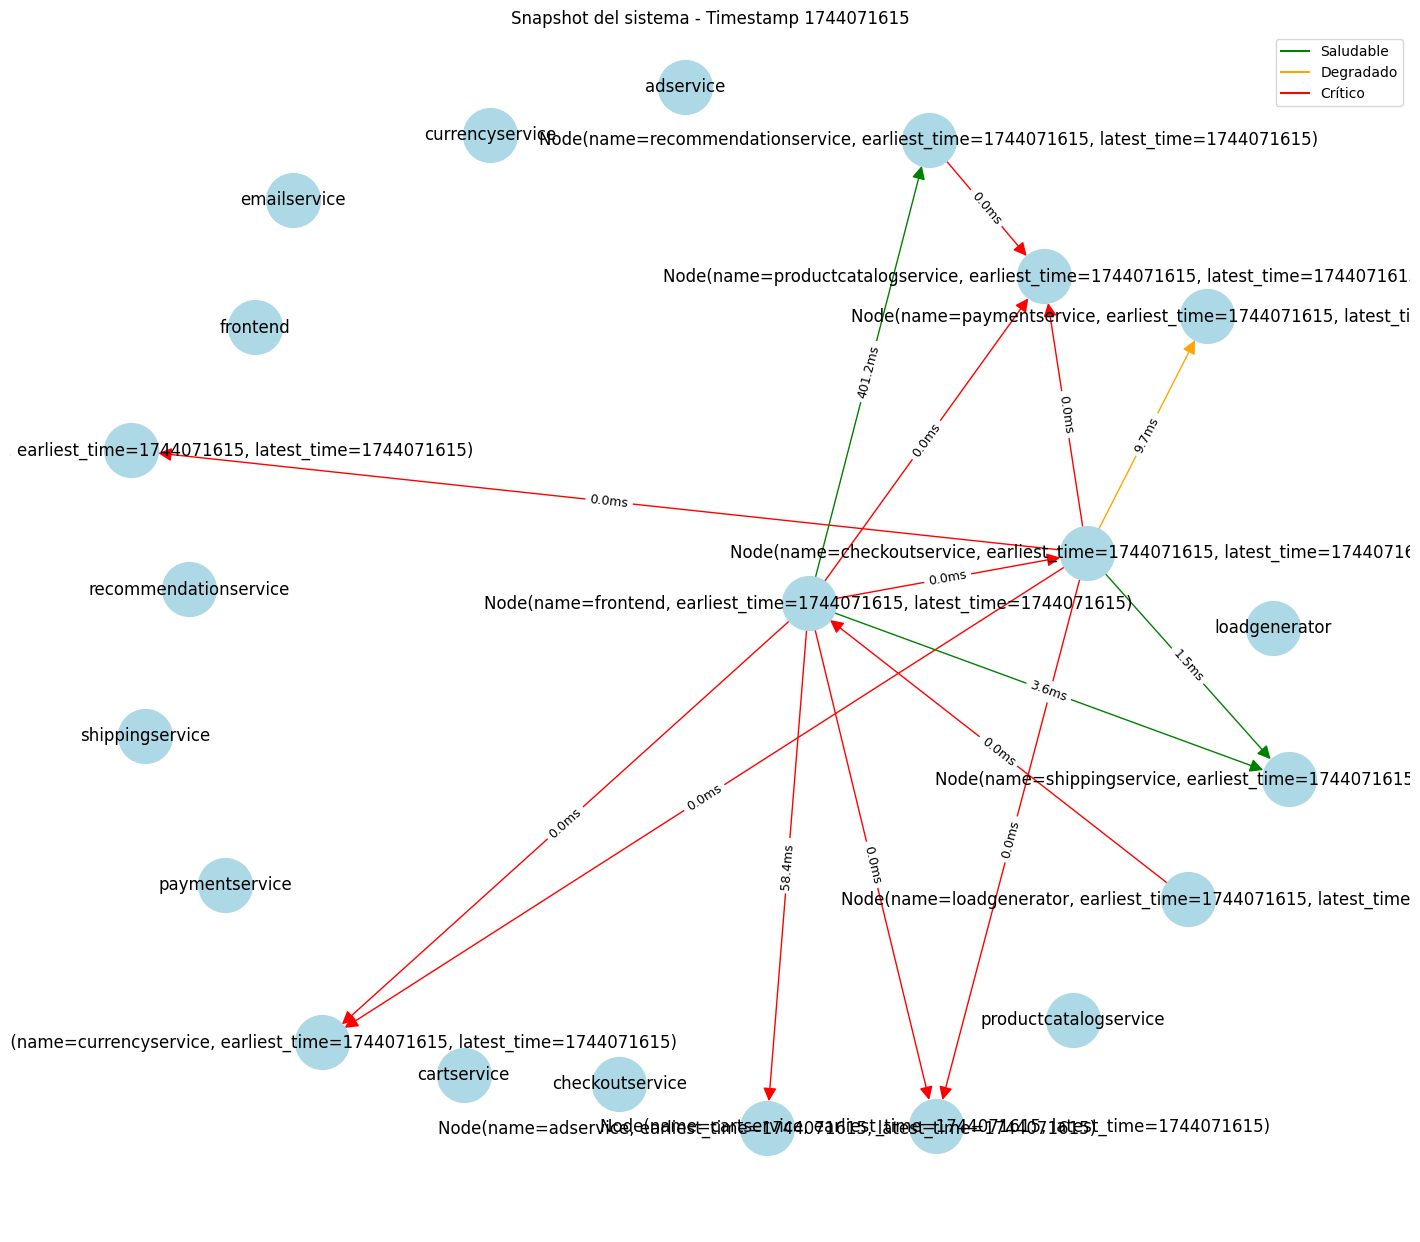

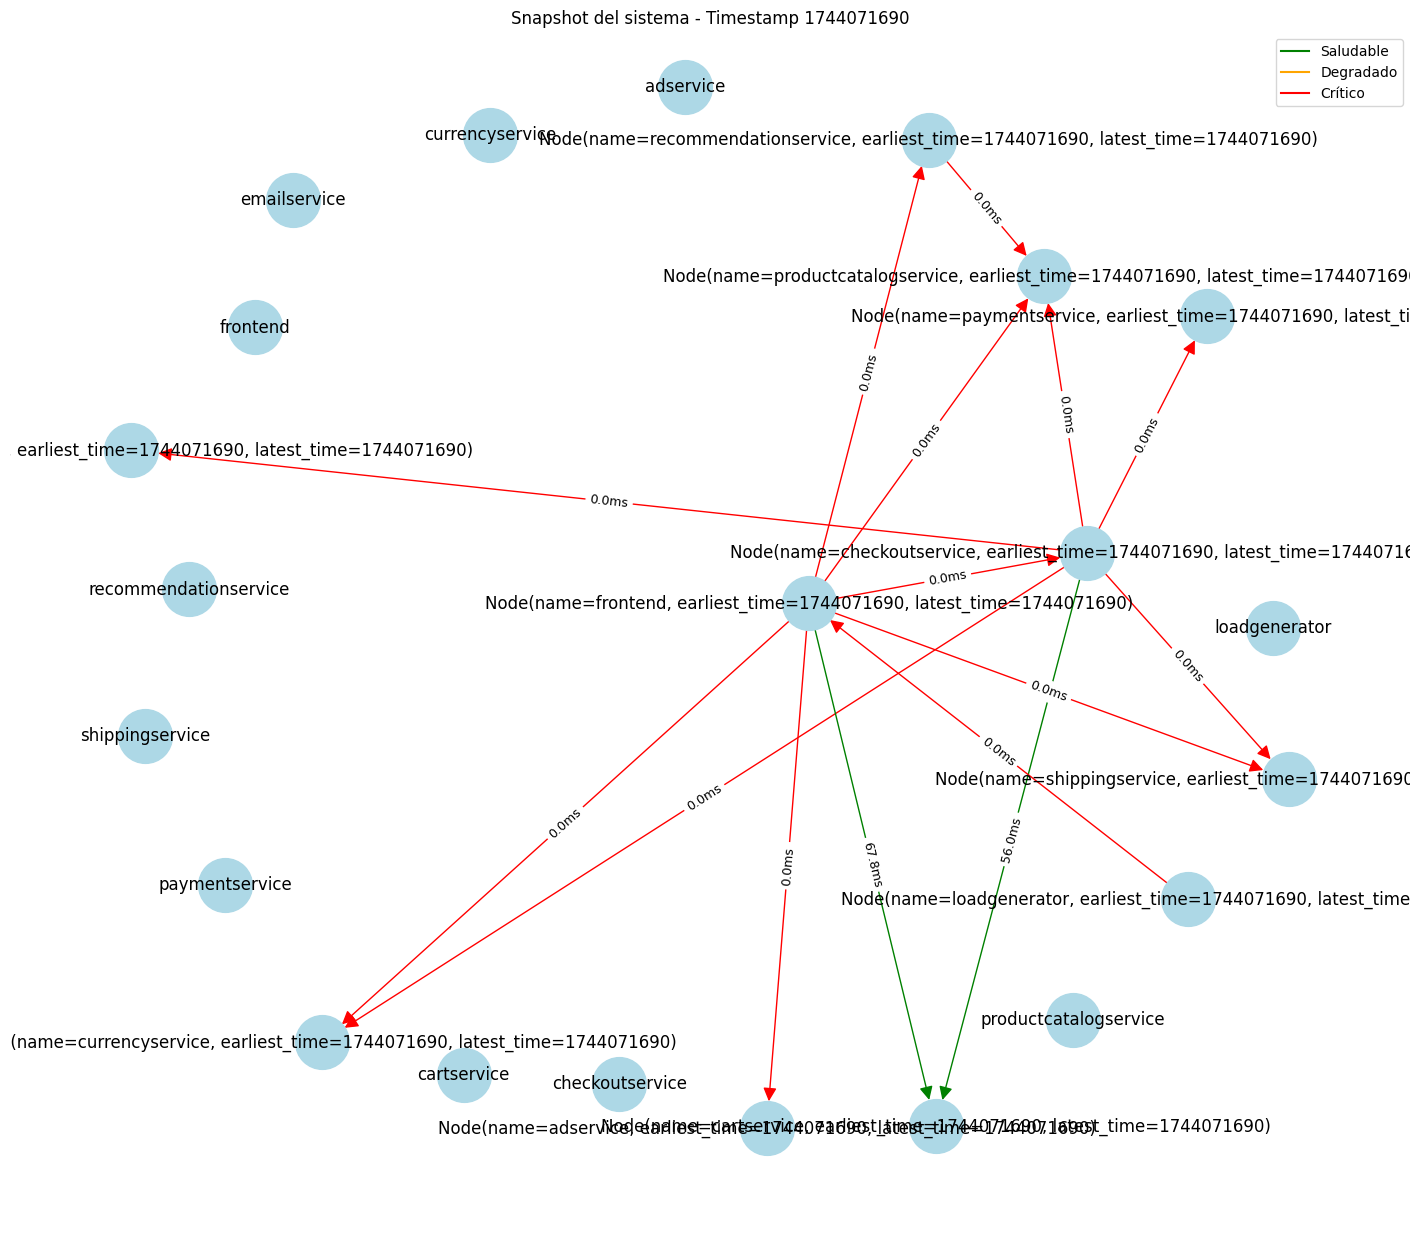

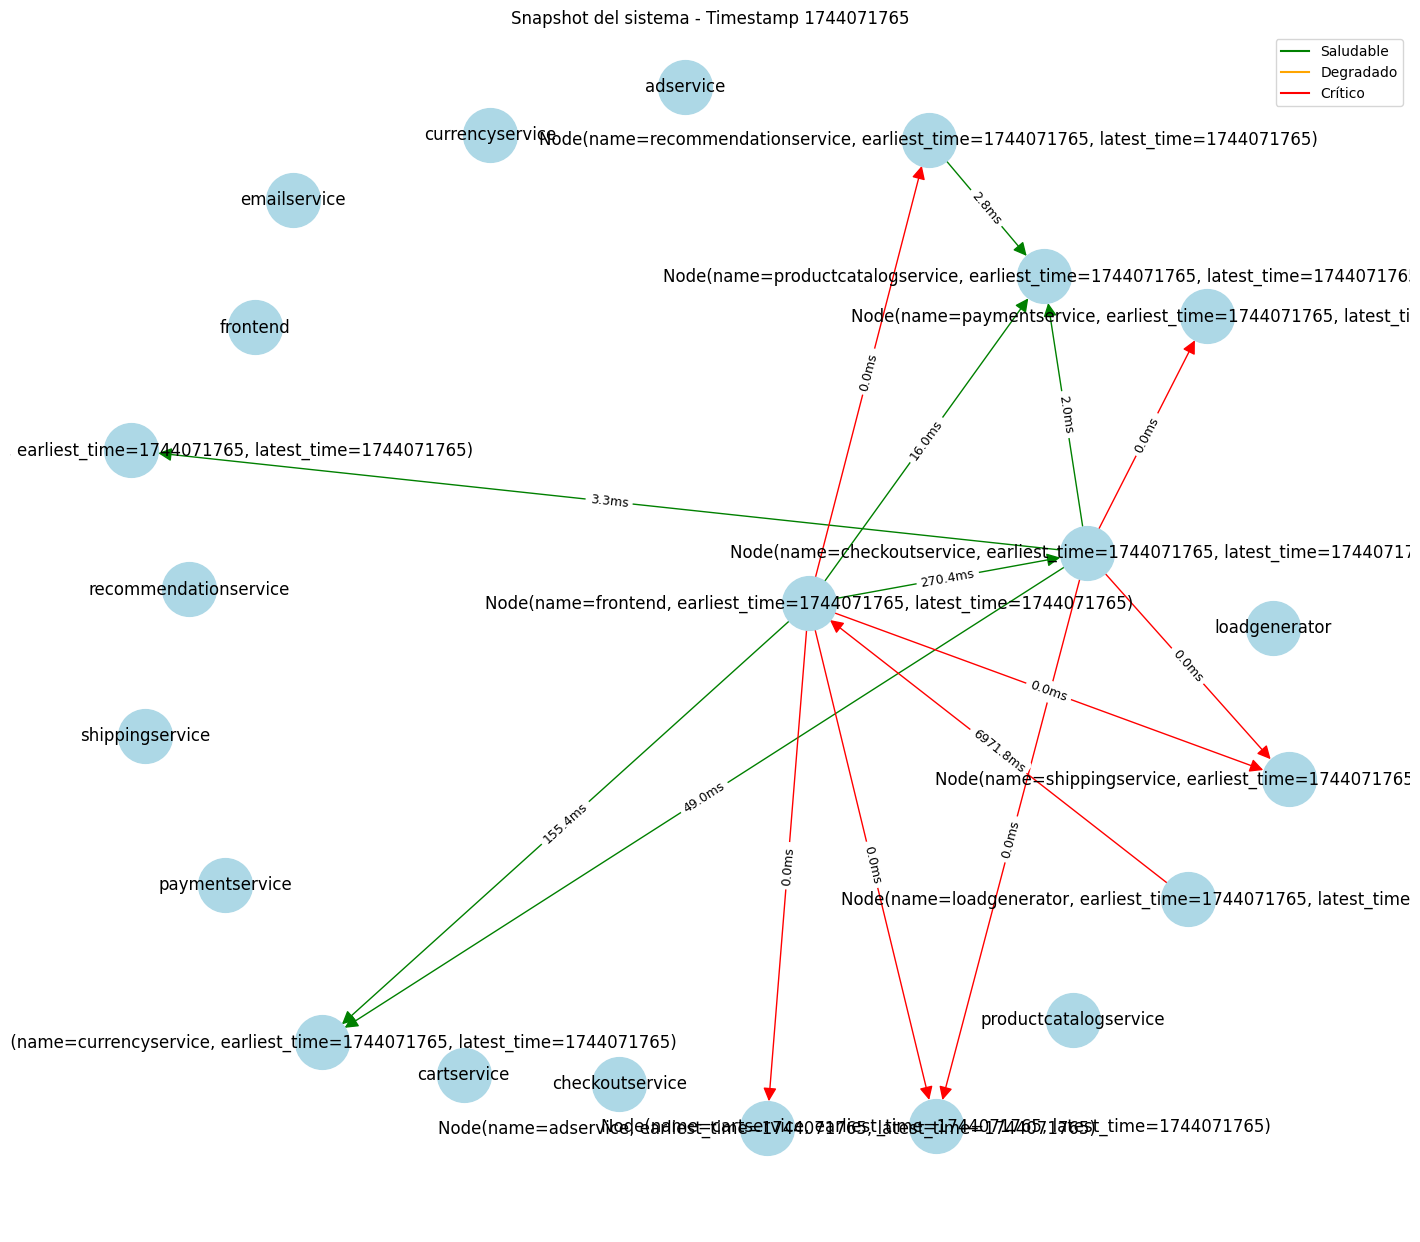

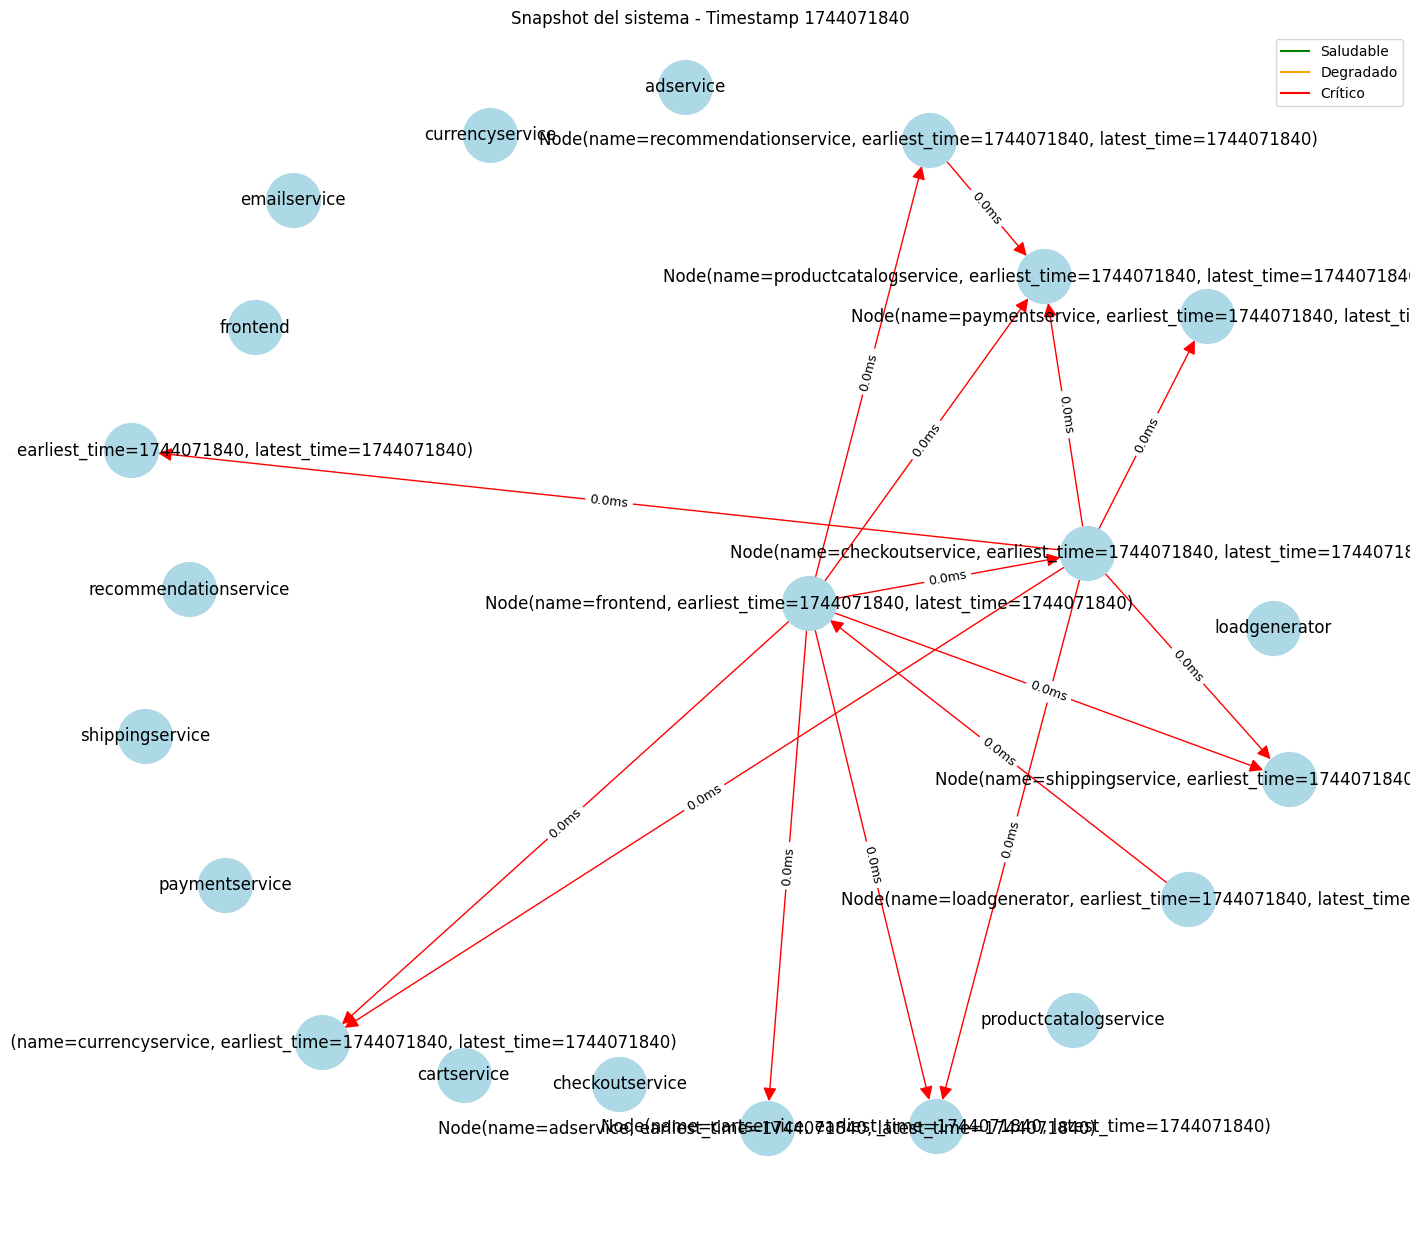

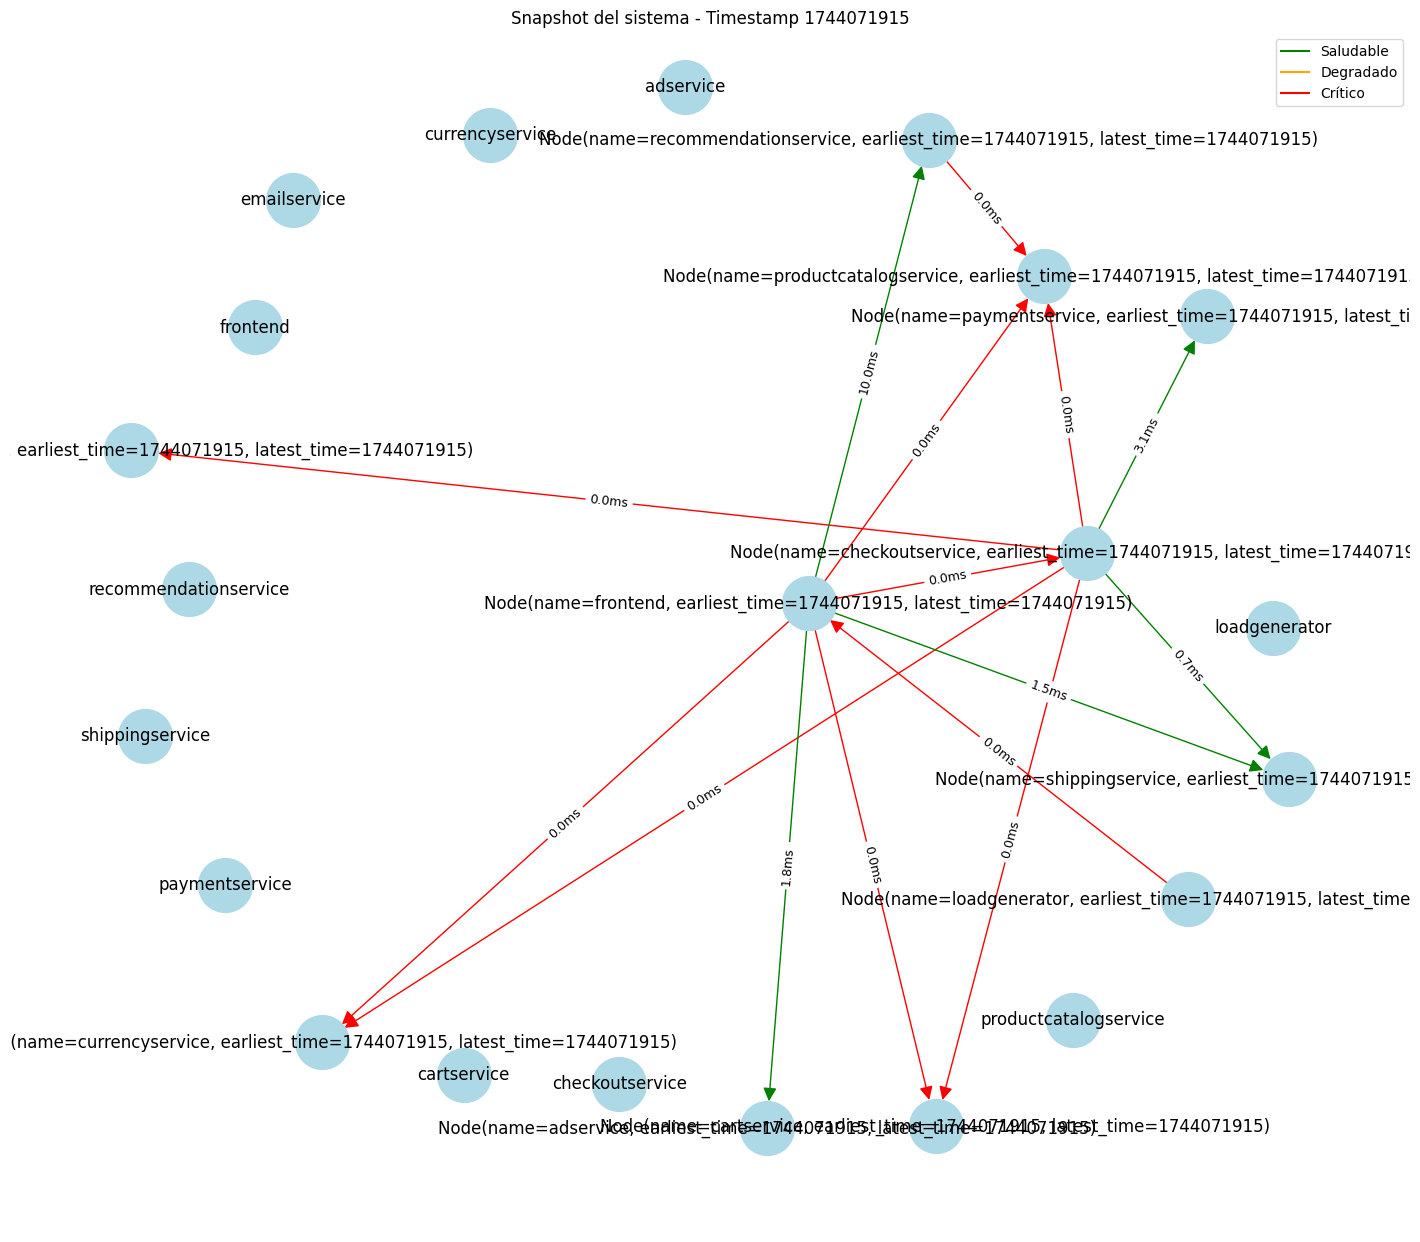

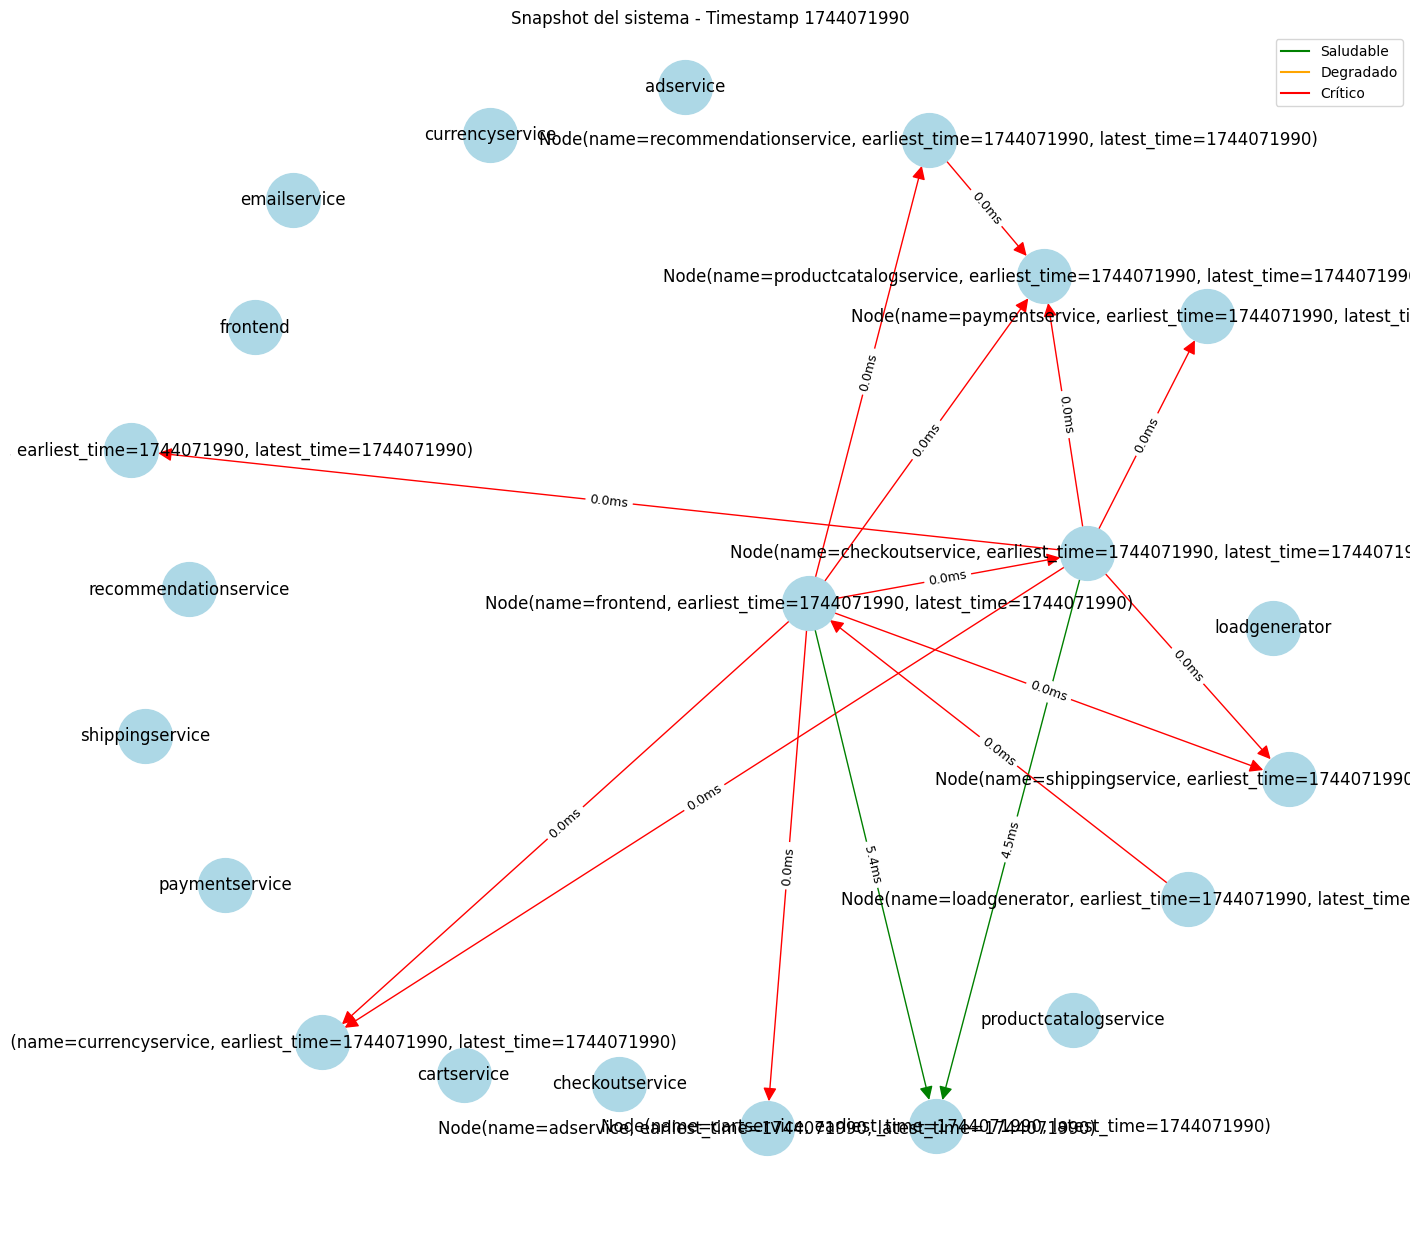

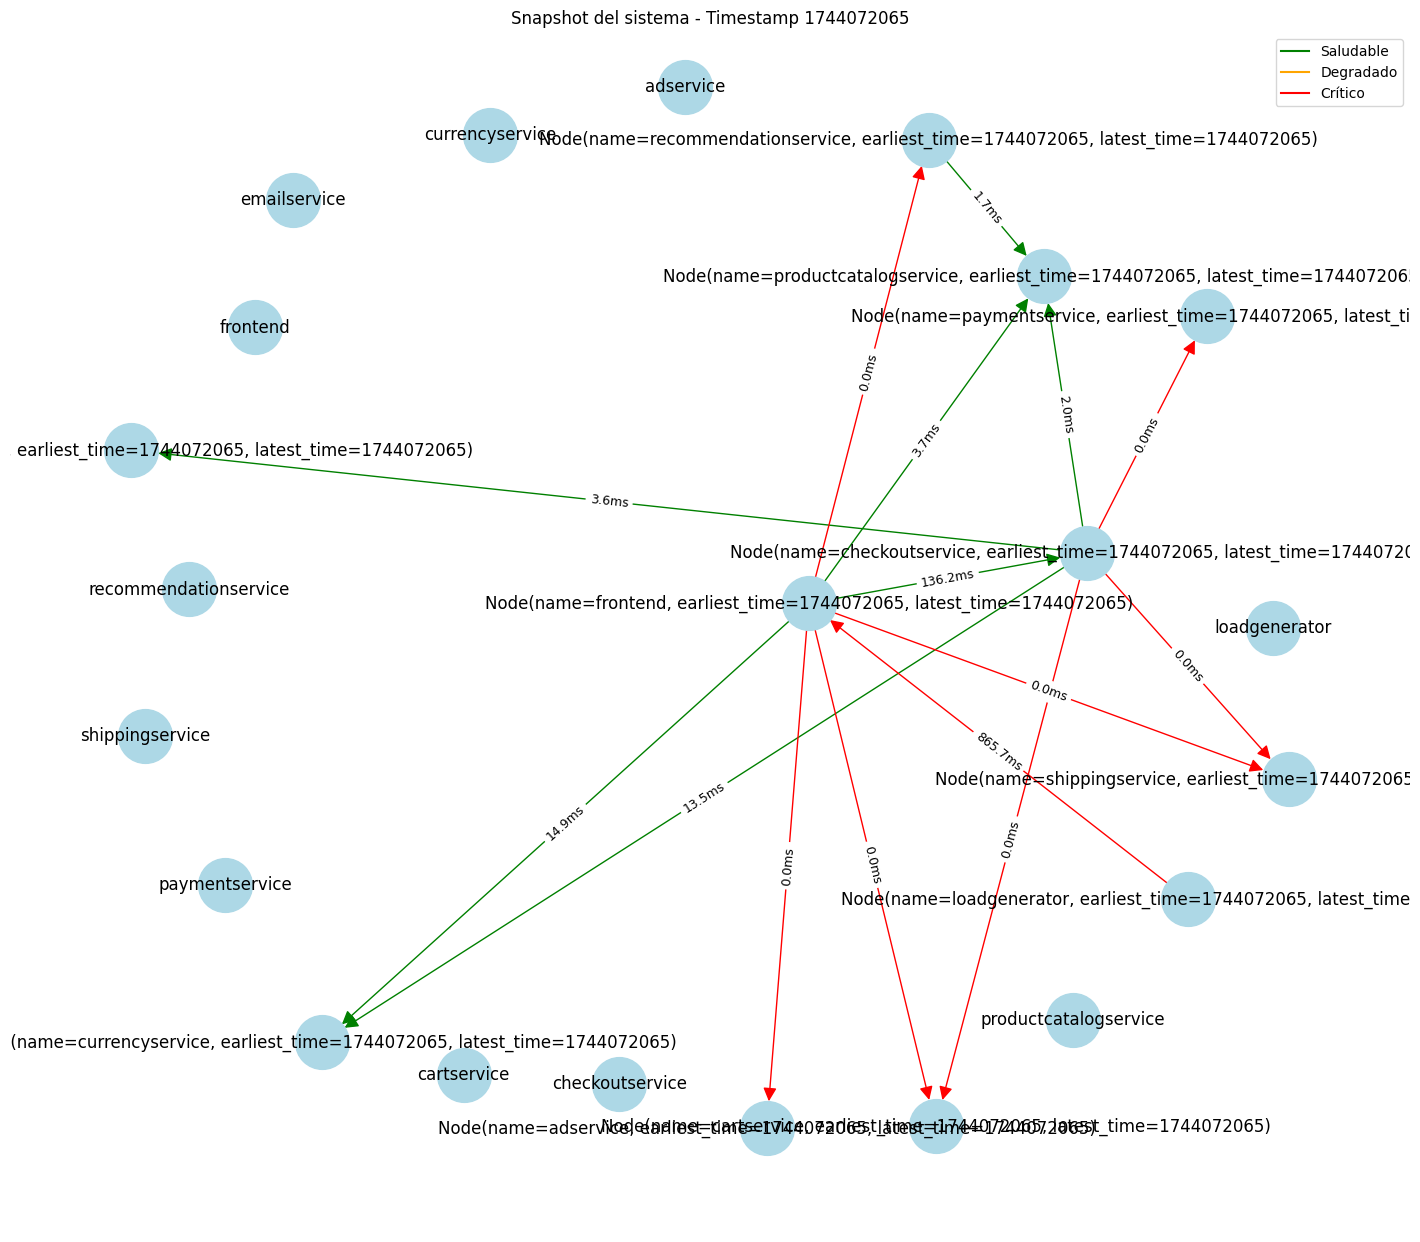

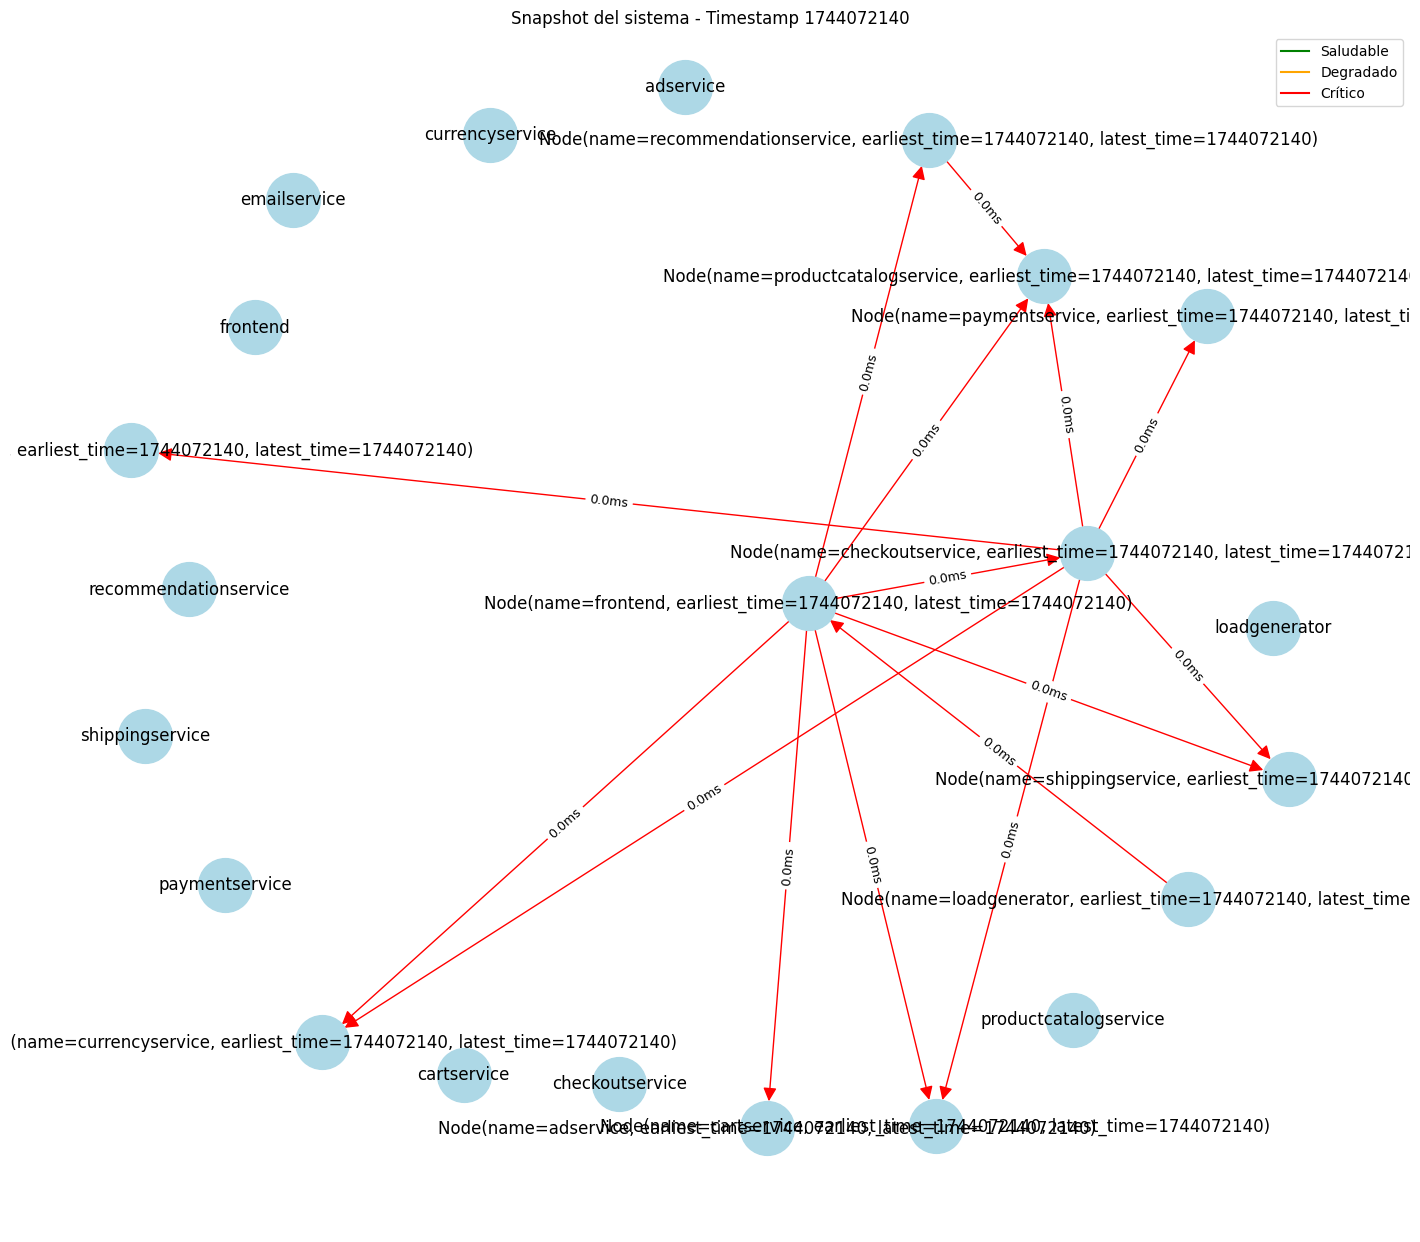

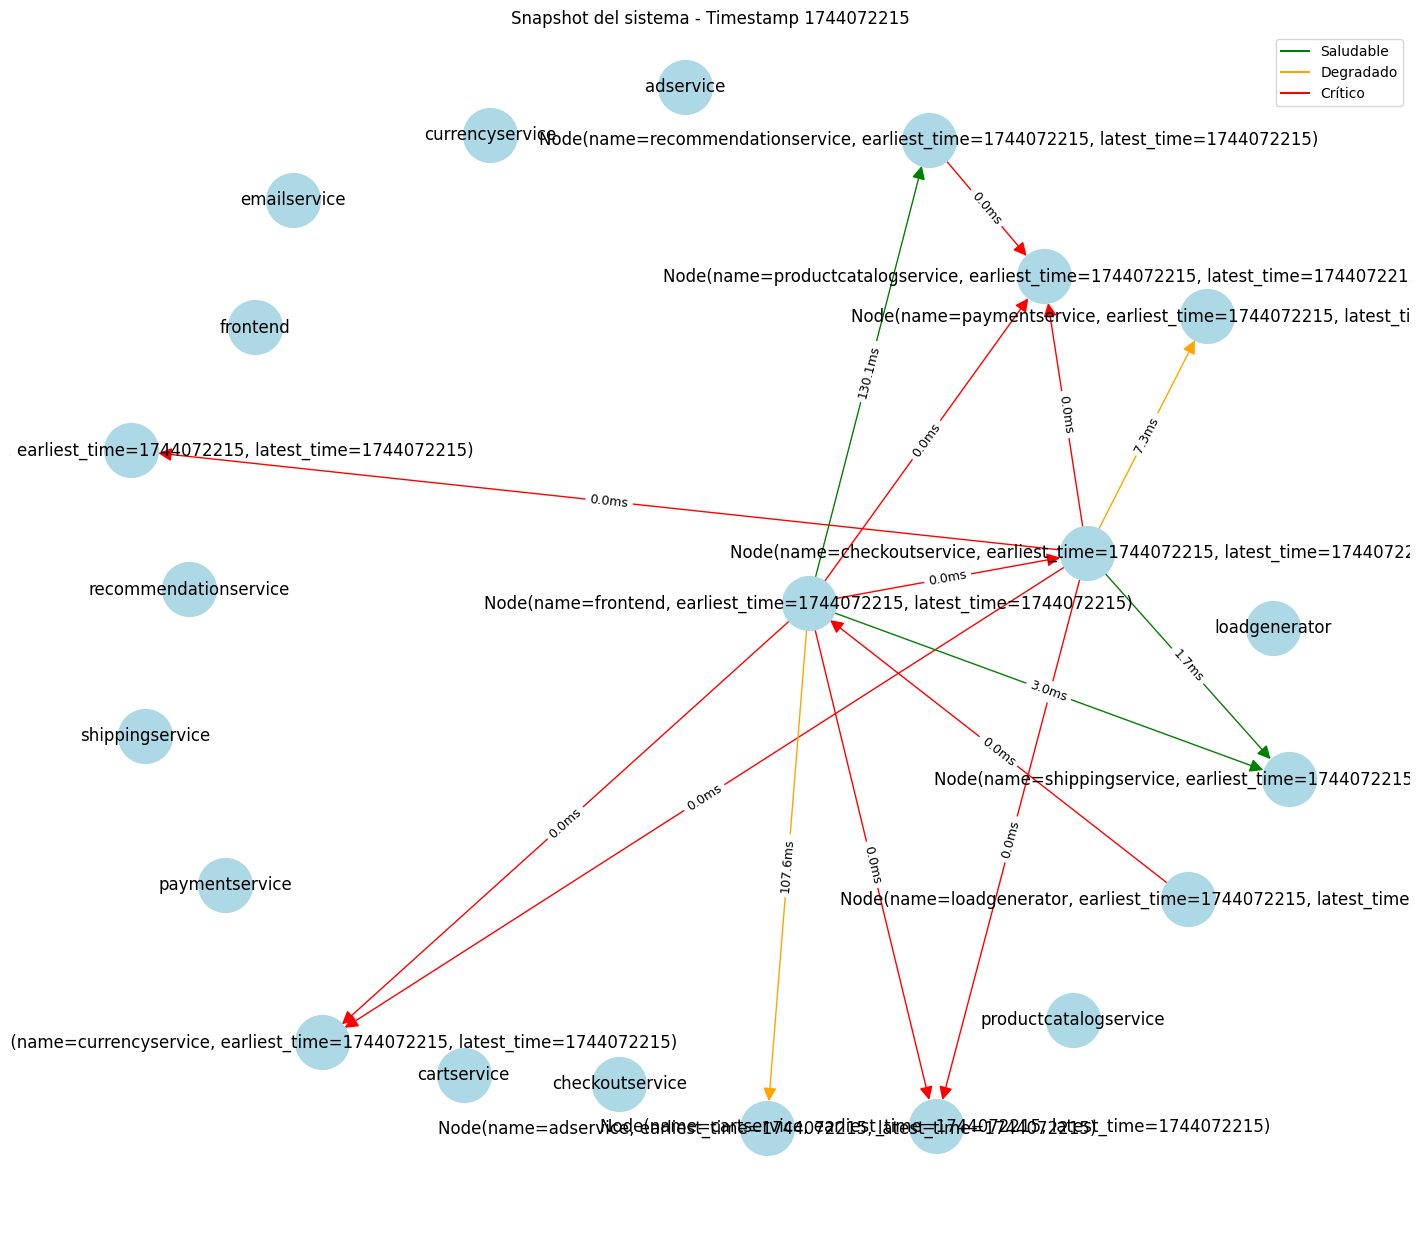

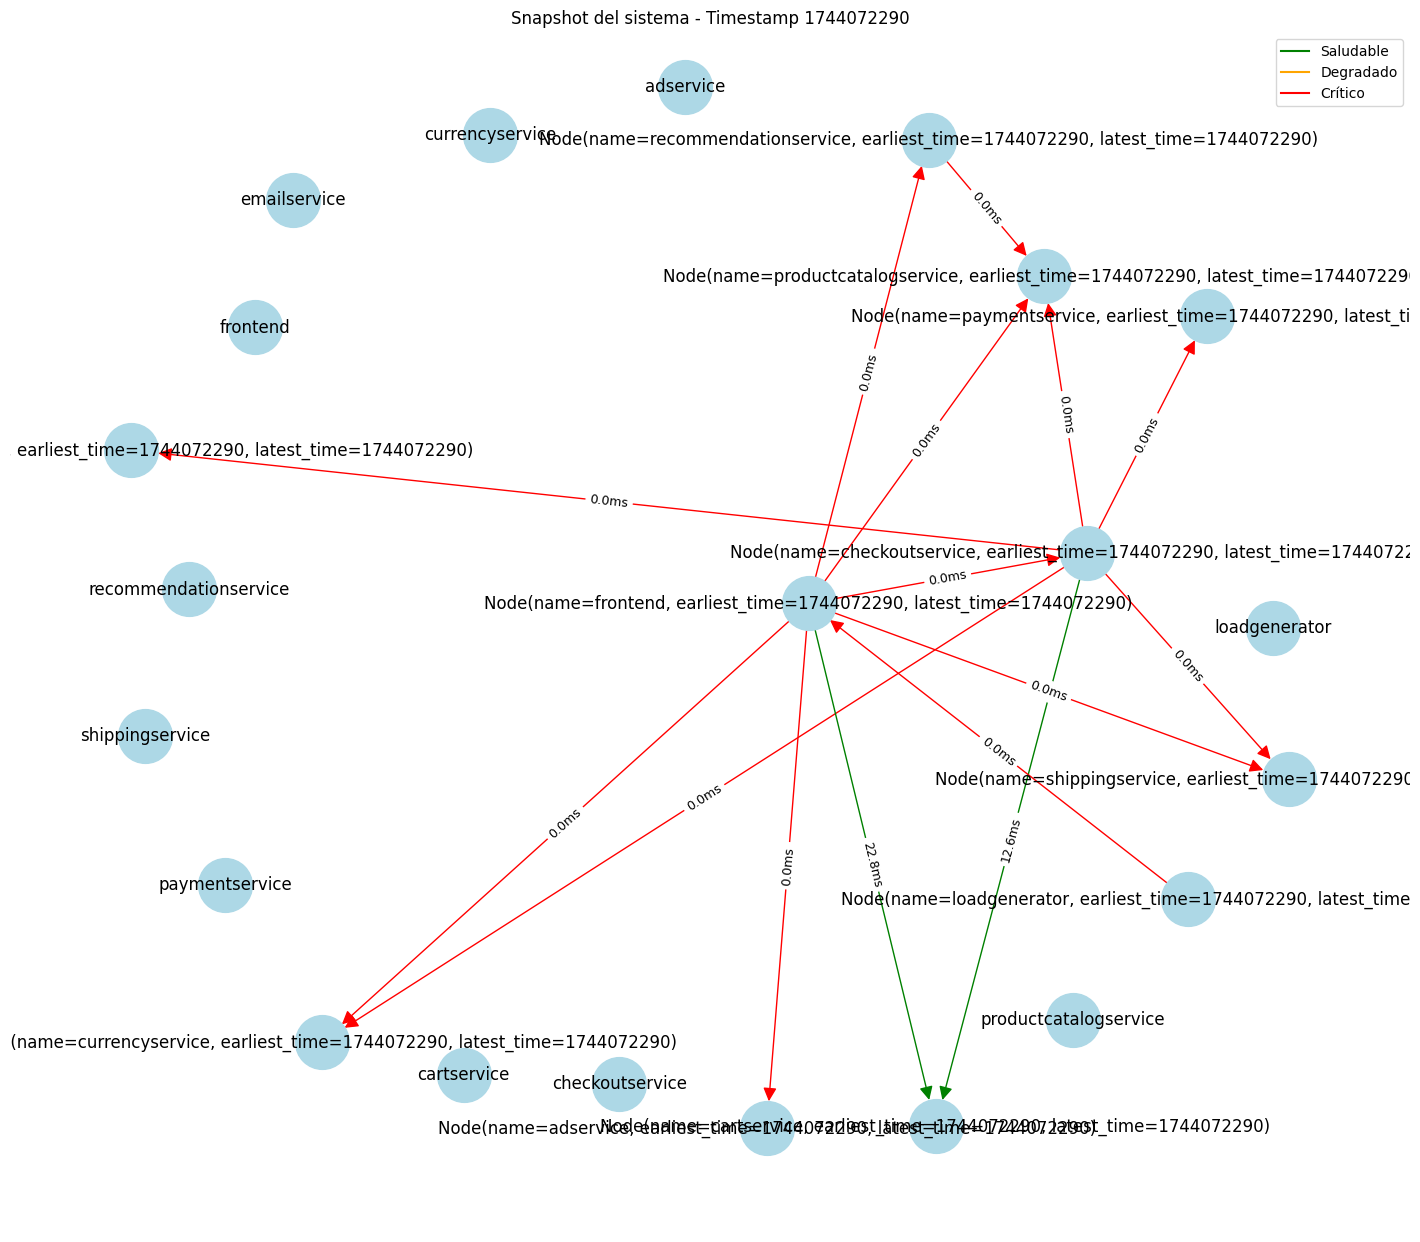

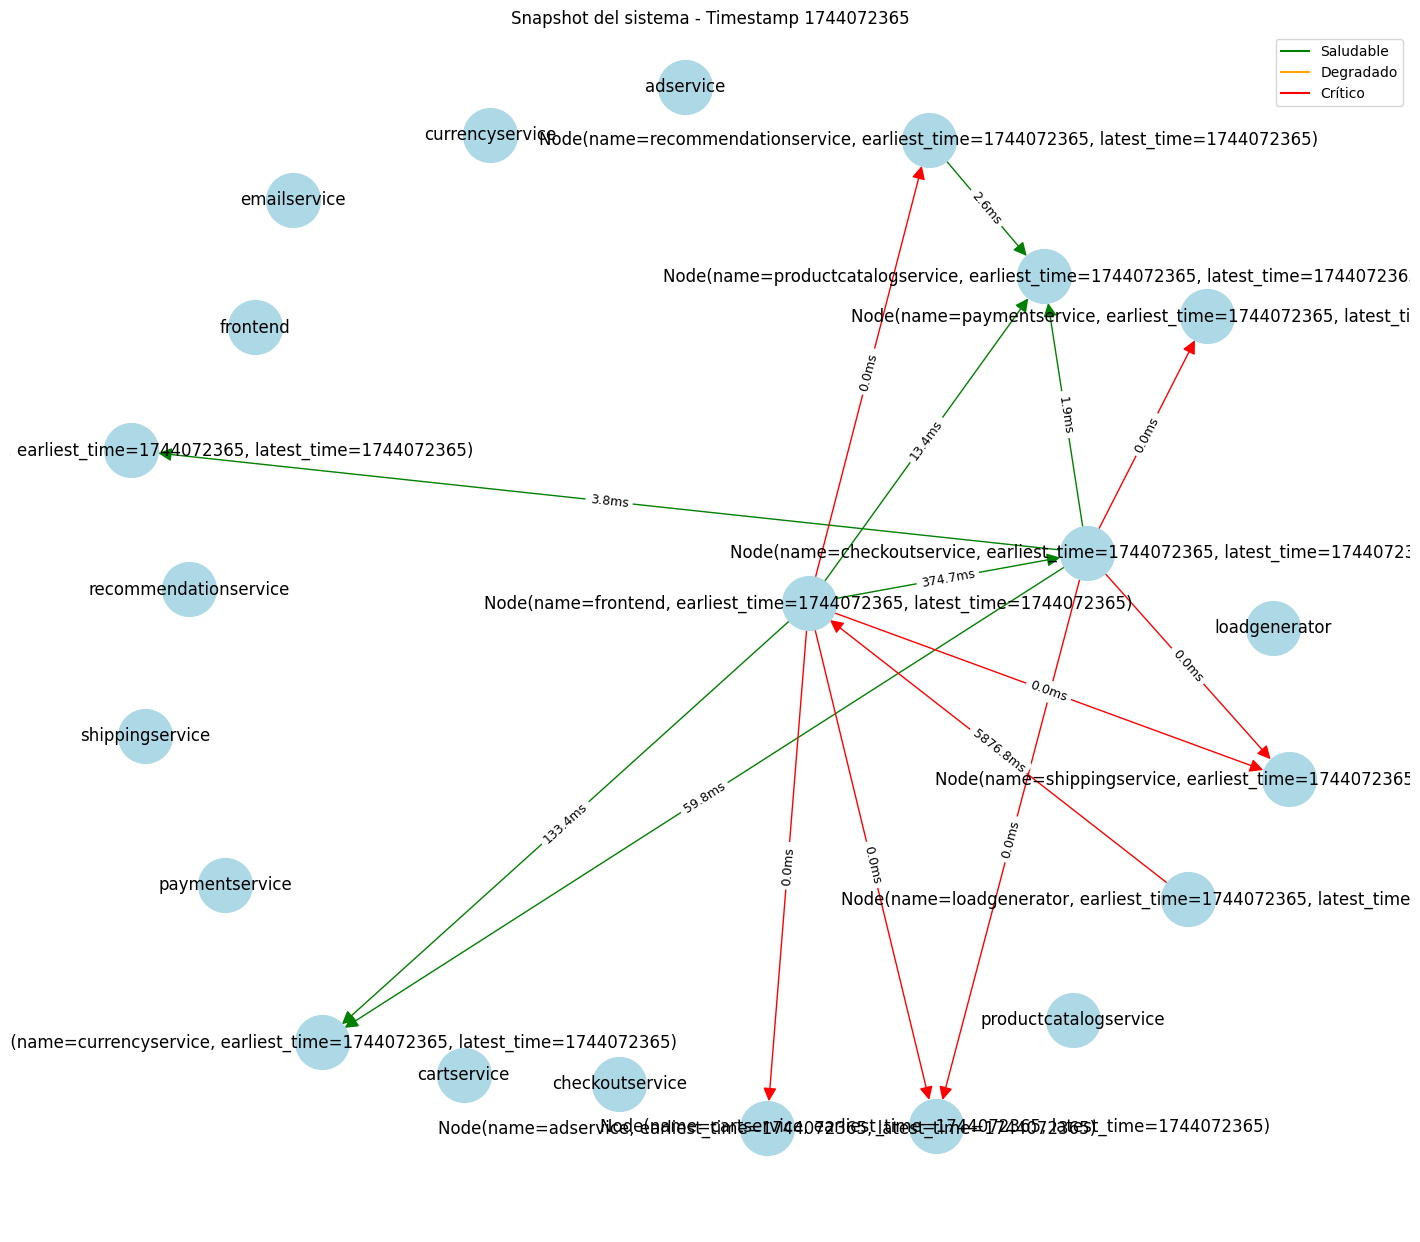

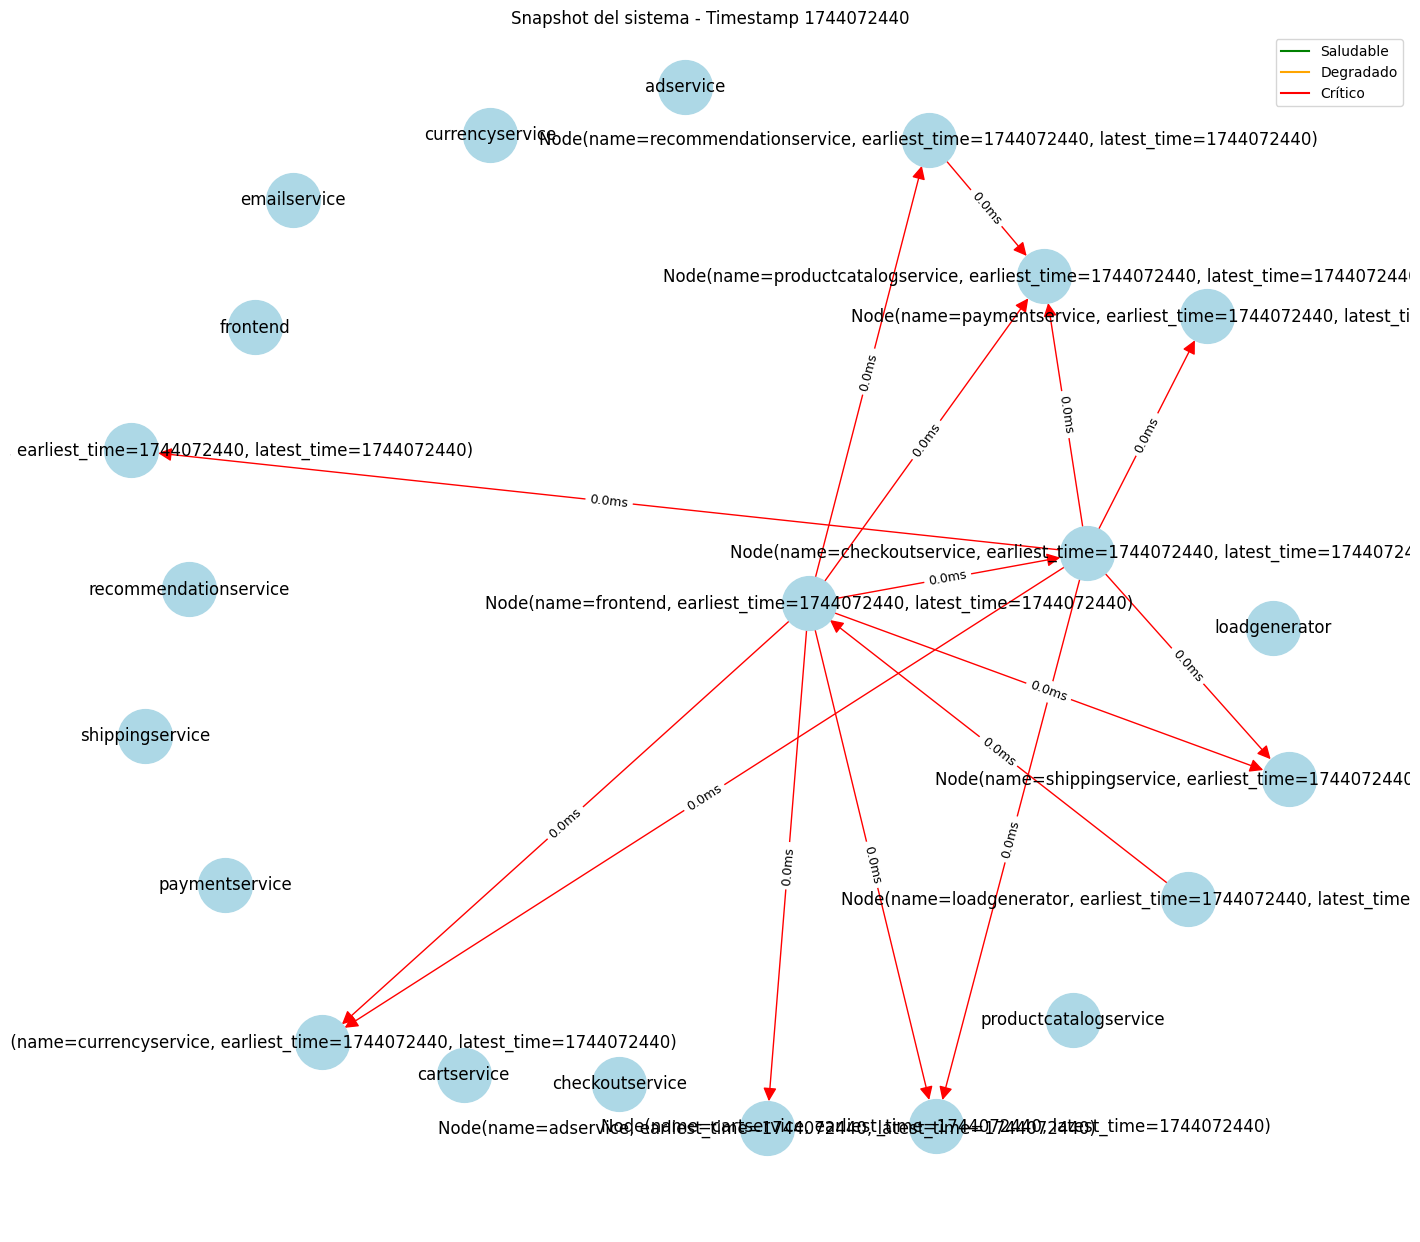

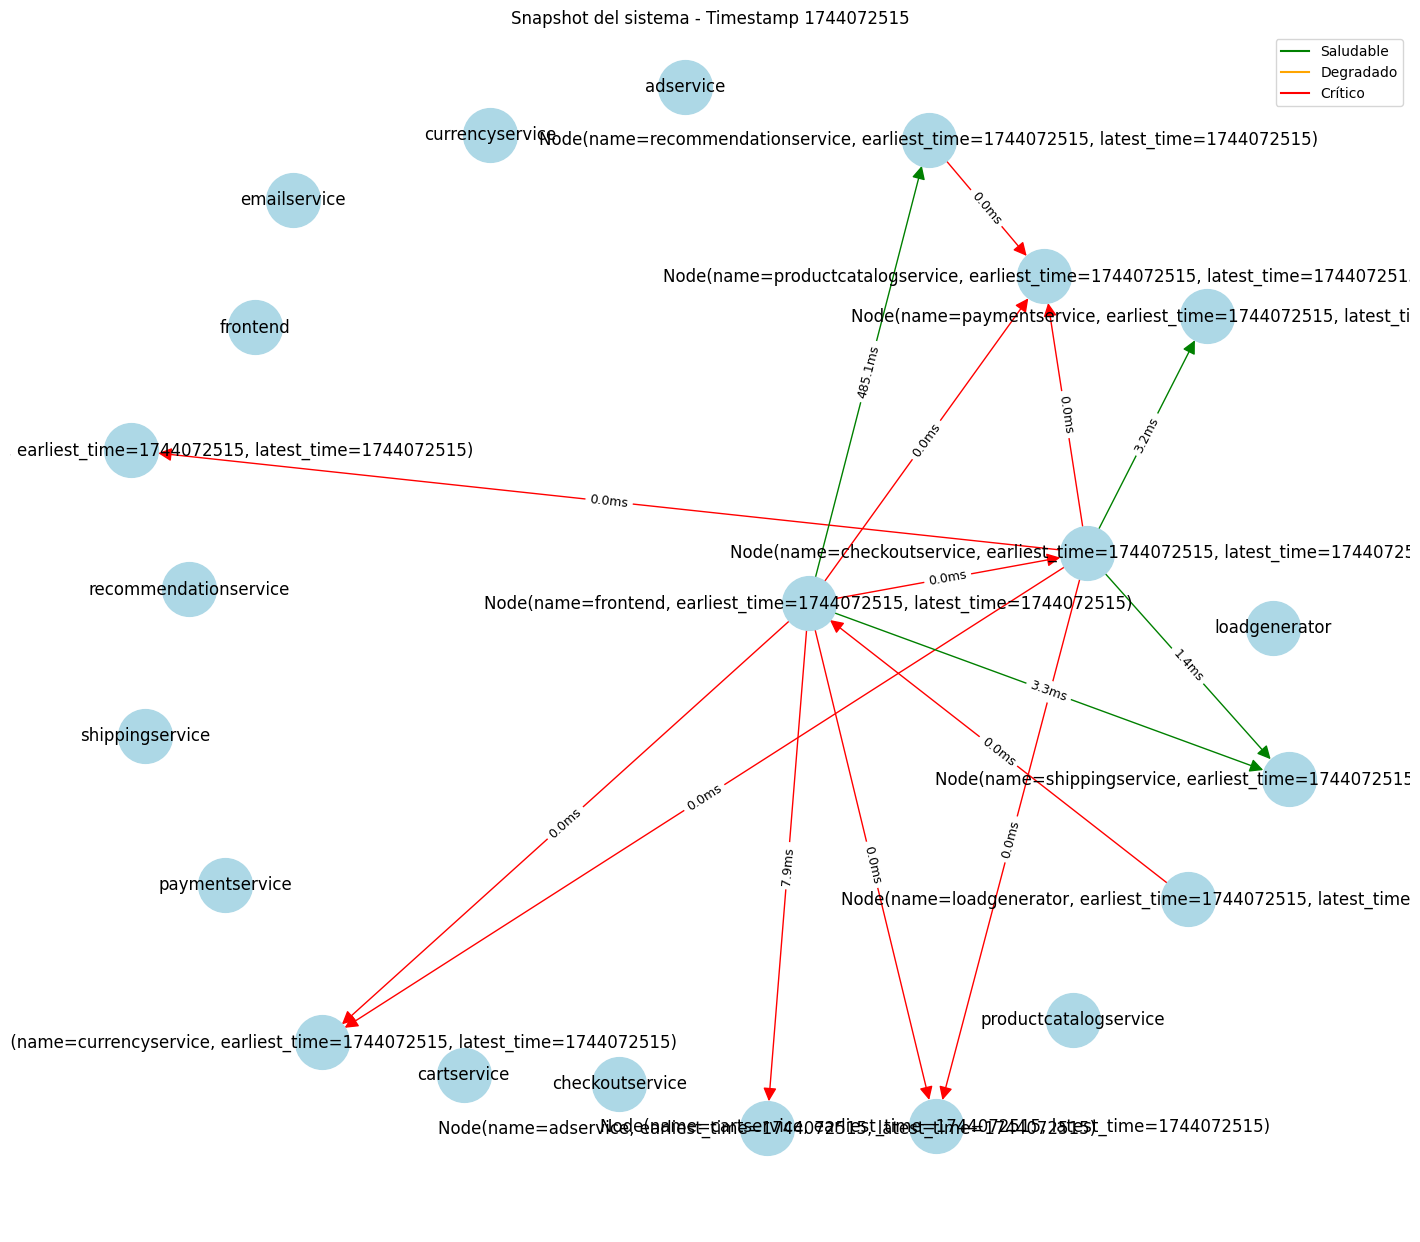

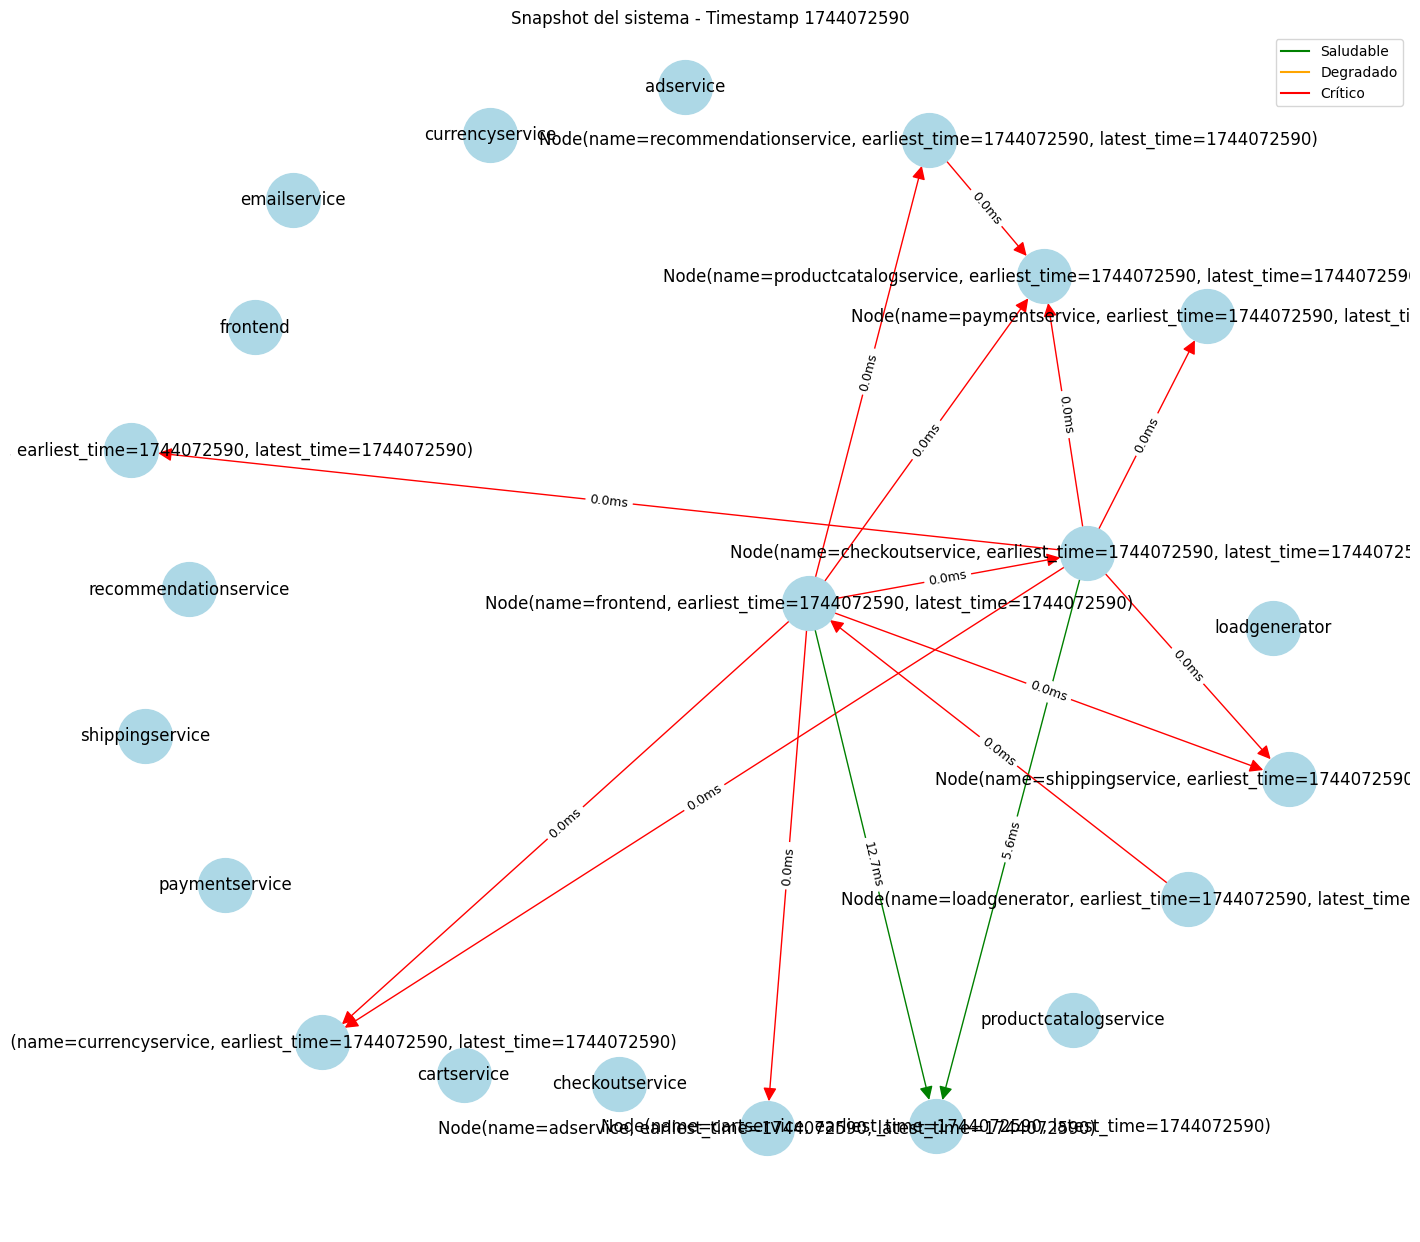

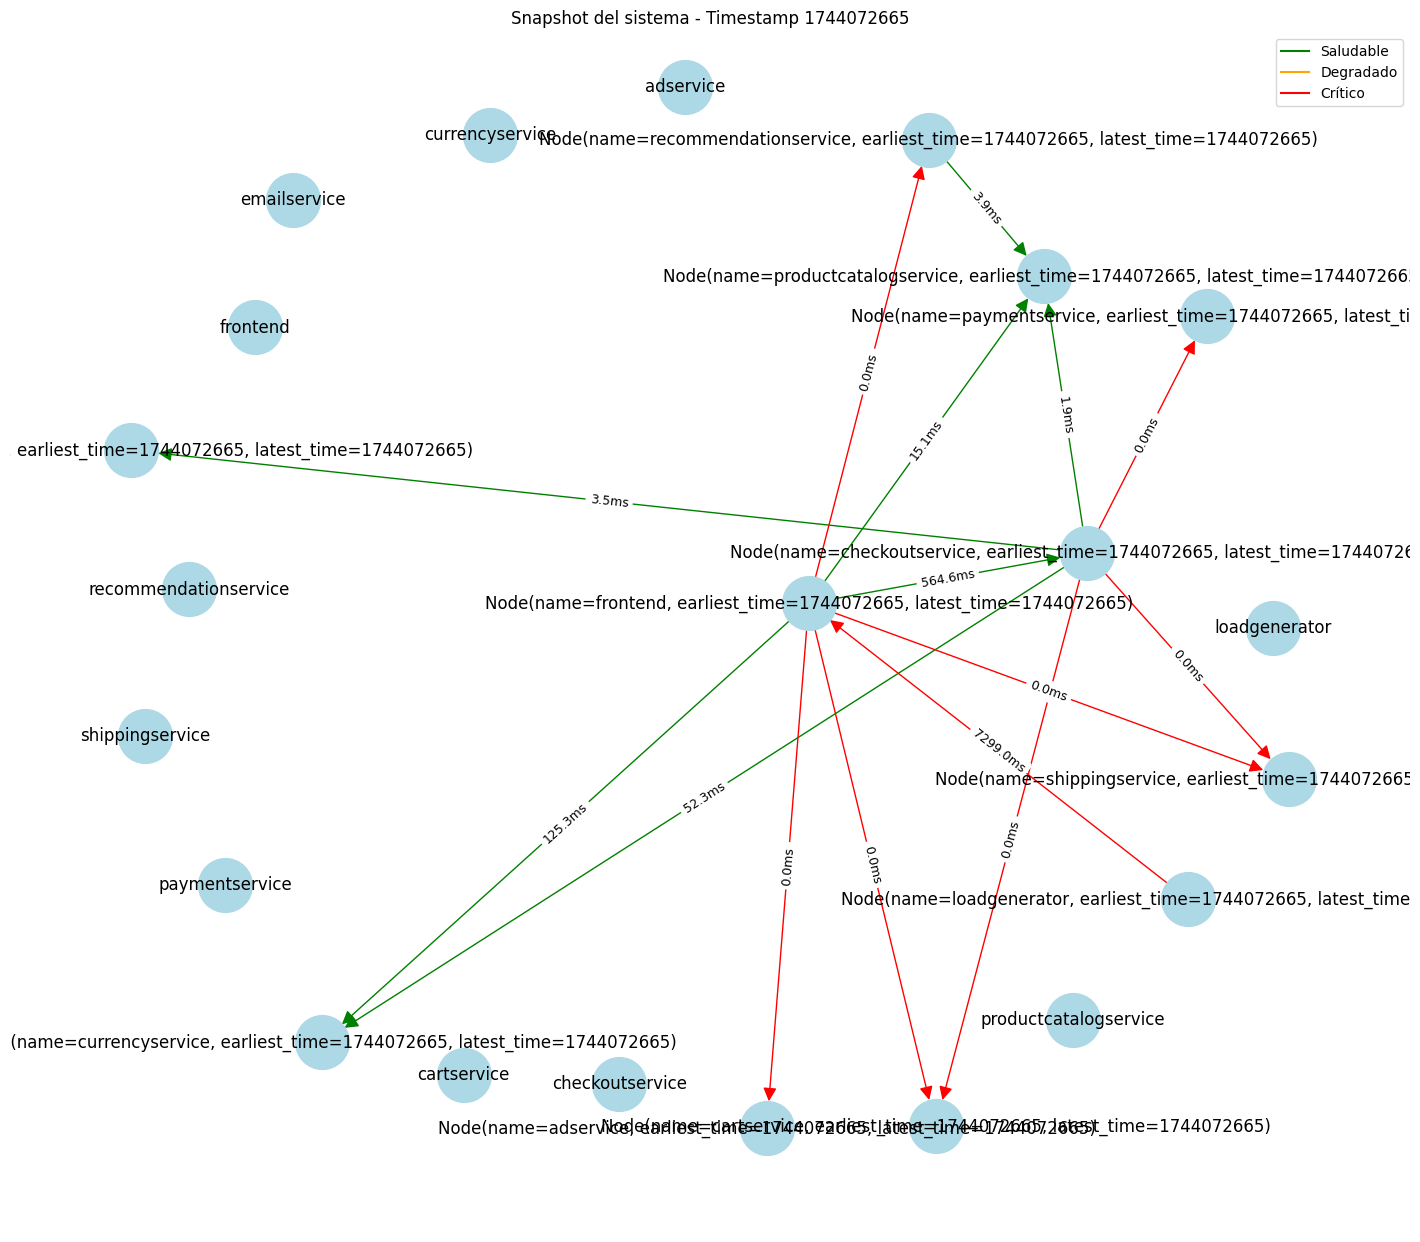

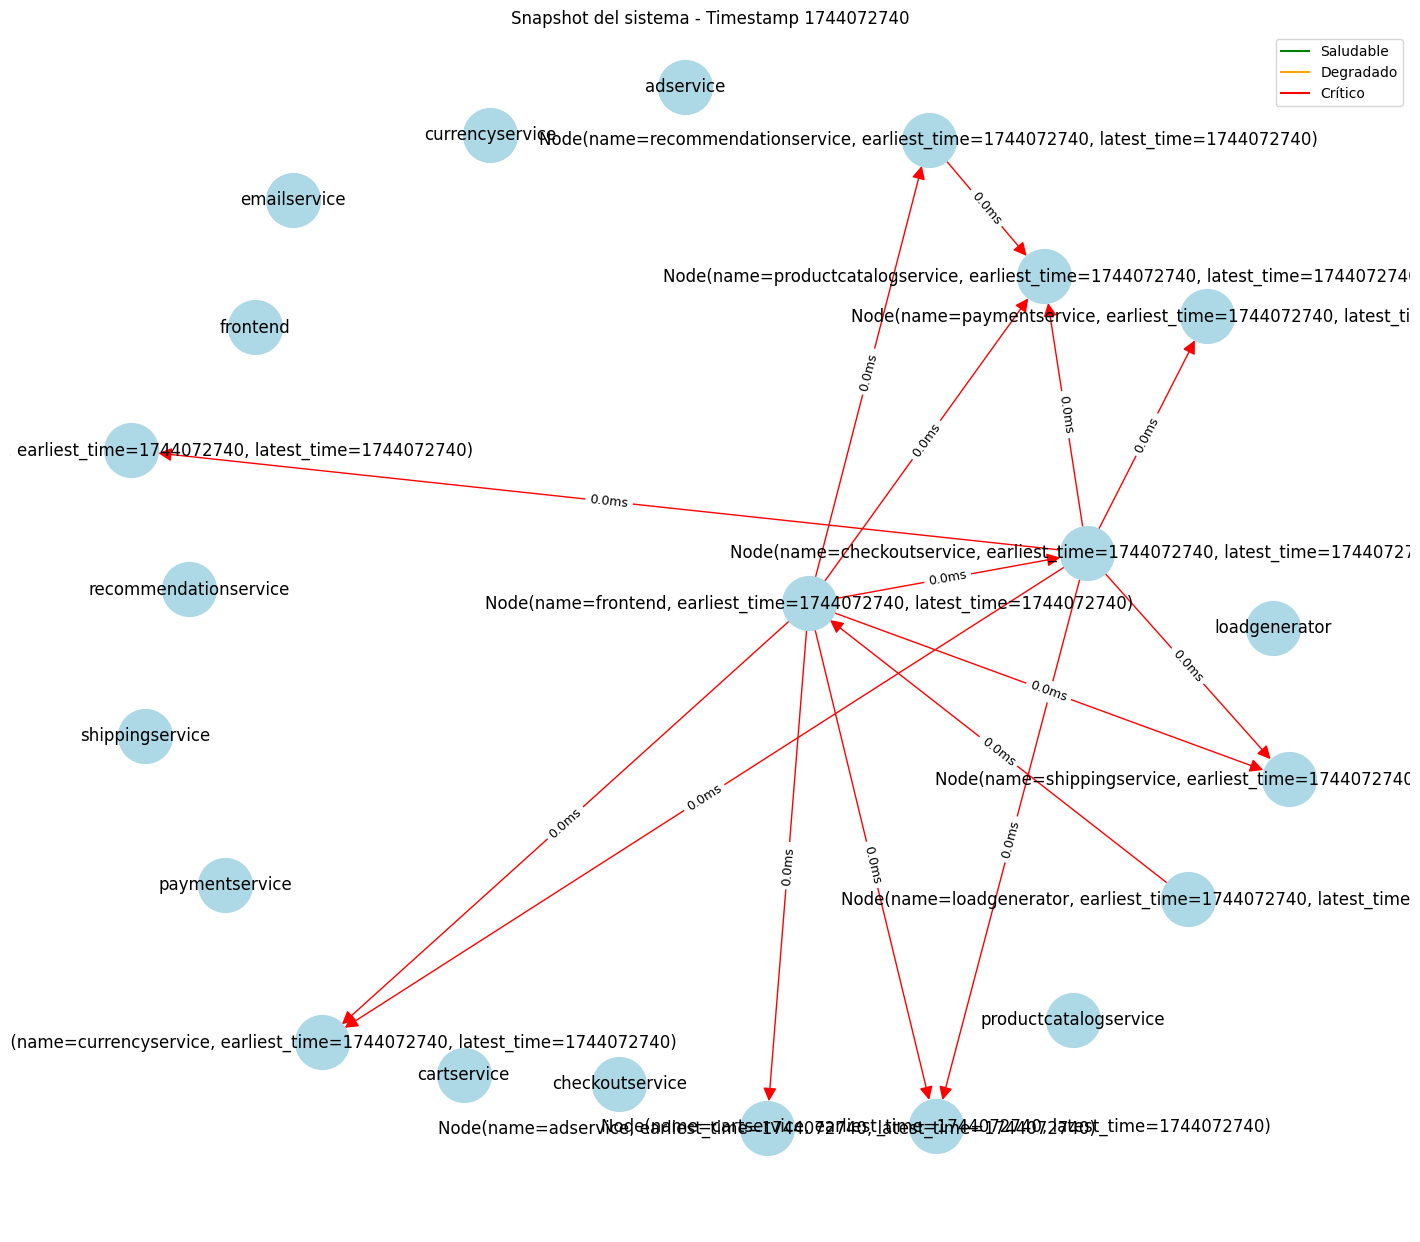

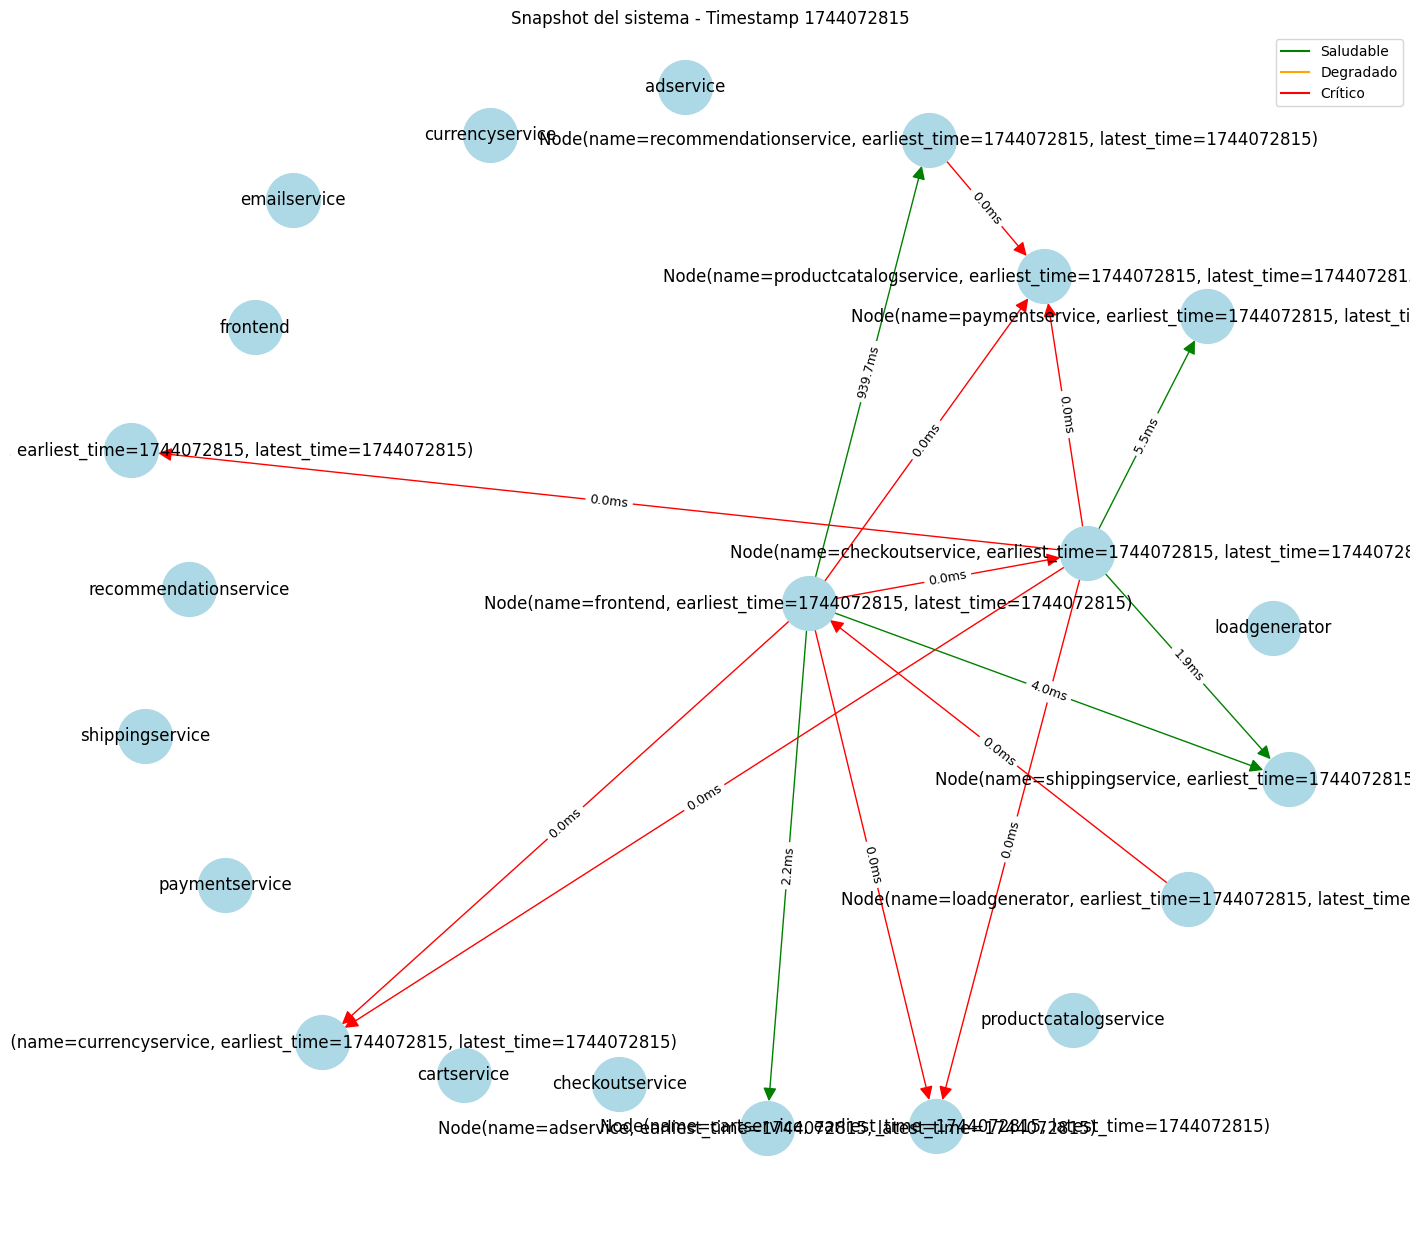

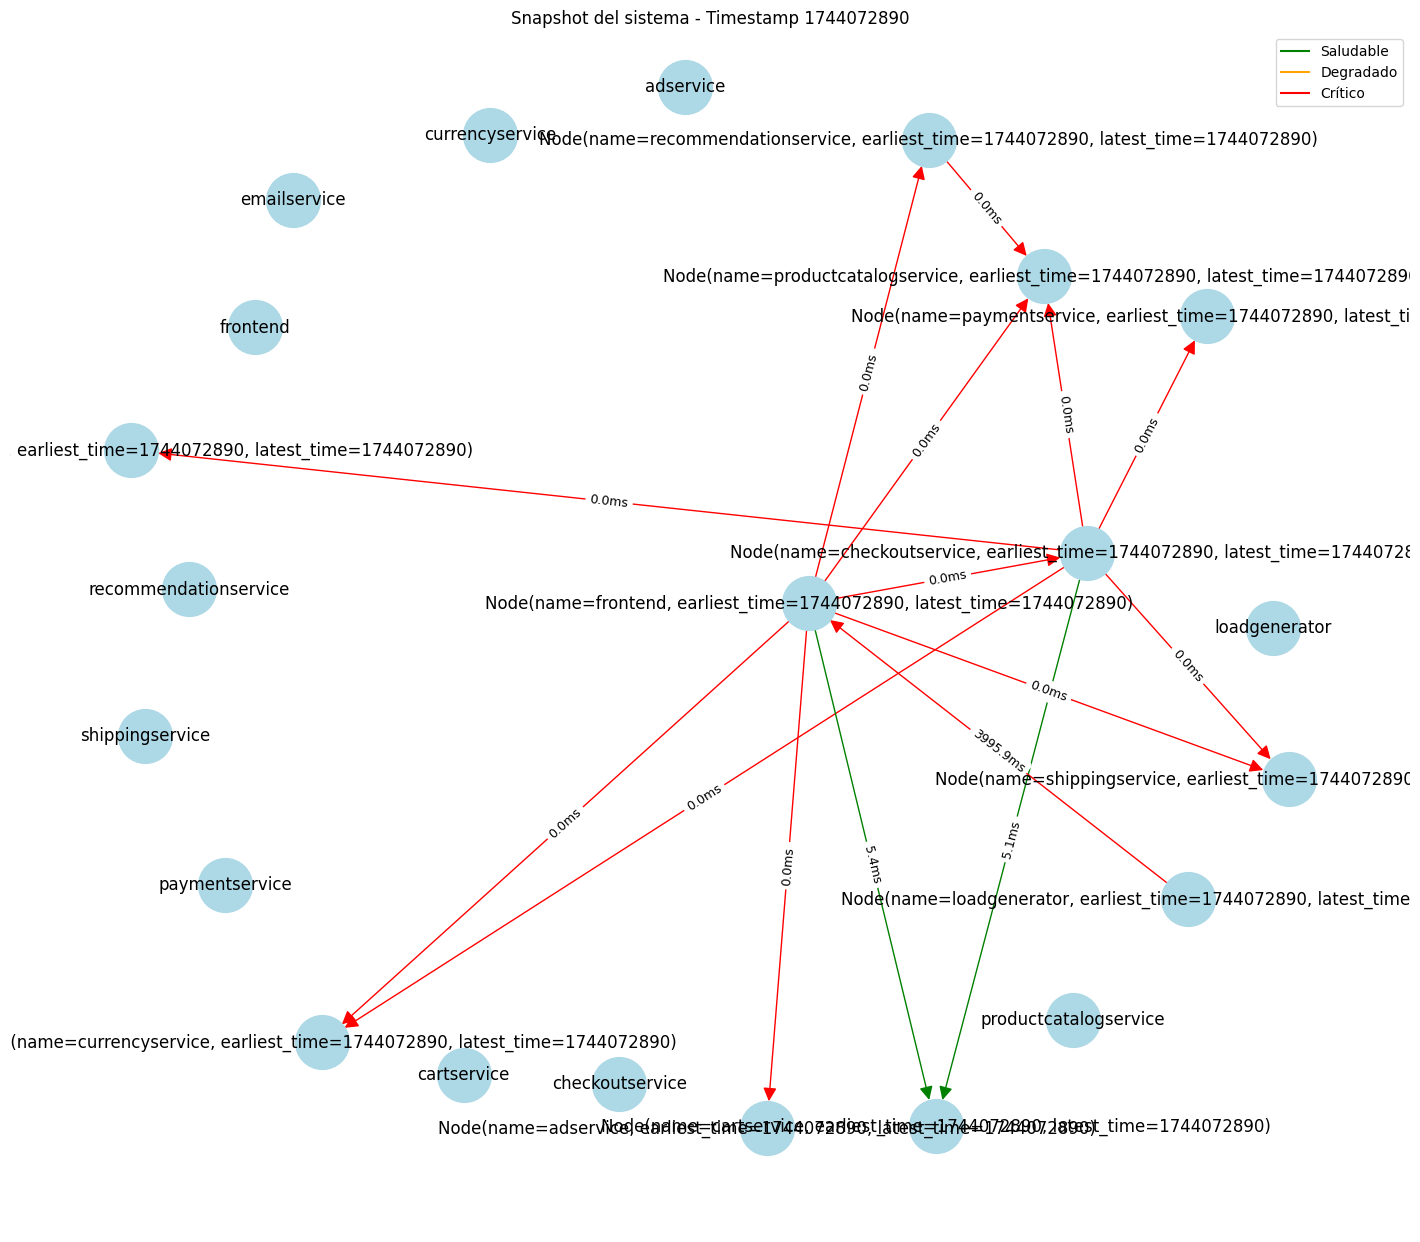

In [1]:

# 📦 Requiere: pip install raphtory pandas networkx matplotlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from raphtory import Graph

# Cargar datos CSV reales
df = pd.read_csv("kiali_kpi_metrics.csv")

# Filtrar y limpiar
df = df[df["time_window"].astype(str).str.strip() == "15S"].copy()
df["timestamp"] = pd.to_datetime(df["timestamp"]).astype(int) // 10**9
df["status"] = df["error_rate"].apply(lambda e: 0 if e < 0.01 else (1 if e < 0.15 else 2))

# Crear grafo temporal
g = Graph()

# Añadir nodos como strings
nodes = set(df["source_workload"]).union(set(df["destination_workload"]))
for node in nodes:
    g.add_node(timestamp=1, id=str(node))  # se puede ajustar el timestamp

# Añadir aristas temporales
for _, row in df.iterrows():
    g.add_edge(
        timestamp=int(row["timestamp"]),
        src=str(row["source_workload"]),
        dst=str(row["destination_workload"]),
        properties={
            "latency": row["average_latency"],
            "status": row["status"]
        }
    )

# Colores de estado
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Crítico"}

# Obtener timestamps únicos y visualizar cada 5
for ts in sorted(df["timestamp"].unique())[::5]:
    snapshot = g.at(ts)
    G_nx = nx.DiGraph()

    for node in snapshot.nodes:
        G_nx.add_node(str(node.name))

    for edge in snapshot.edges:
        props = edge.properties
        status = props["status"] if "status" in props else 0
        latency = props["latency"] if "latency" in props else 0
        G_nx.add_edge(edge.src, edge.dst, status=status, latency=latency)

    edge_colors = [color_map[G_nx[u][v]['status']] for u, v in G_nx.edges()]
    edge_labels = {(u, v): f"{G_nx[u][v]['latency']:.1f}ms" for u, v in G_nx.edges()}

    plt.figure(figsize=(14,12))
    pos = nx.spring_layout(G_nx, seed=50,  k=2)
    nx.draw(G_nx, pos, with_labels=True, edge_color=edge_colors,
            node_color='lightblue', node_size=1500, arrowsize=20)
    nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels, font_size=9)

    for s, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[s])
    plt.legend(loc='upper right')
    plt.title(f"Snapshot del sistema - Timestamp {ts}")
    plt.show()
